# Projeto prático de Inteligencia artificial 2023/2024
#### Realizado por:
* Amílcar Justino nº2222179
* Diogo Abegão nº2222184

## Passos para elaboração do Modelo S


---


# Funções reutilizaveis



---
* Funcoes para desenhar os gráficos
* Funcao para desenhar a matriz de confusão
* Função para mostrar uma amostra criada por data-augmentation



In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def plotLossAccuracy(history):
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='train accuracy')
    plt.plot(history.history['val_accuracy'], label='validation accuracy')
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(loc='upper left')

    # Plot training & validation loss values
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='train loss')
    plt.plot(history.history['val_loss'], label='validation loss')
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(loc='upper left')
    plt.show()

def plotValidationLoss(history):
    print(history)
    val_loss = history.history["val_loss"]
    epochs = range(1, len(val_loss) + 1)
    plt.plot(epochs, val_loss, "b--",
    label="Validation loss")
    plt.title("Effect of insufficient model capacity on validation loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()

def plotConfusionMatrix(model, test_dataset):
    y_true = []
    y_pred = []

    print('Processing confusion matrix. May take some time...')
    for images, labels in test_dataset:
        y_true.extend(labels.numpy())
        predictions = model.predict(images,verbose=0)
        y_pred.extend(np.argmax(predictions, axis=1))

    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    matrix = confusion_matrix(y_true, y_pred)
    # Plot the confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=matrix, display_labels=test_dataset.class_names)
    disp.plot(cmap=plt.cm.Blues, values_format='d')

    plt.xticks(rotation=90)
    plt.title('Confusion Matrix')
    plt.show()

def plotDataAugmentationImagee(train_dataset, data_augmentation):
    plt.figure(figsize=(10, 10))
    for images, _ in train_dataset.take(1):
        for i in range(4):
            augmented_images = data_augmentation(images)
            ax = plt.subplot(2, 2, i + 1)
            plt.imshow(augmented_images[0].numpy().astype("uint8"))
            plt.axis("off")


---


# Importaçao das imagens de treino, validação e teste.


---



In [ ]:
USING_COLAB = False
from keras.utils import image_dataset_from_directory

IMG_SIZE = 32
BATCH_SIZE = 64

if USING_COLAB:
  from google.colab import drive
  drive.mount('/content/drive')

  import zipfile
  zip_ref = zipfile.ZipFile("/content/drive/MyDrive/train.zip", 'r')
  zip_ref.extractall("/content/train")
  zip_ref = zipfile.ZipFile("/content/drive/MyDrive/validation.zip", 'r')
  zip_ref.extractall("/content/validation")
  zip_ref = zipfile.ZipFile("/content/drive/MyDrive/test.zip", 'r')
  zip_ref.extractall("/content/test")
  zip_ref.close()
  TRAIN_DIR = '/content/train/train'
  VALIDATION_DIR = '/content/validation/validation'
  TEST_DIR = '/content/test/test'
  MODELS_DIR = '/content/drive/MyDrive/models'
else:
  TRAIN_DIR = 'data/train'
  VALIDATION_DIR = 'data/validation'
  TEST_DIR = 'data/test'
  MODELS_DIR = 'models'

train_dataset = image_dataset_from_directory(TRAIN_DIR, image_size=(IMG_SIZE, IMG_SIZE), batch_size=BATCH_SIZE)
validation_dataset = image_dataset_from_directory(VALIDATION_DIR, image_size=(IMG_SIZE, IMG_SIZE), batch_size=BATCH_SIZE)
test_dataset = image_dataset_from_directory(TEST_DIR, image_size=(IMG_SIZE, IMG_SIZE), batch_size=BATCH_SIZE)

Found 40000 files belonging to 10 classes.
Found 10000 files belonging to 10 classes.
Found 10000 files belonging to 10 classes.




---


# Criação do modelo


---
Considerando o tipo de modelo que queremos construir, baseando nos apontamentos teóricos e o o livro "Deep Learning with Python", foi decidido começar com uma base que considerando o o tamanho da imagem utilizado, permita ter um feature map resultante de 4x4. Assim, optámos por 3 camadas convolucionais e 1 camada de classificação. Nas camadas convolucionais foram escolhidos 32, 64, 128 neuronios respetivamente. Na camada de classificação, para já uma camada de saida com 10 neurónios, permitindo obter um modelo que consiga classificar 10 tipos de imagens. Neste contexto, o signal de ativação mais indicado é o softmax complementado com a compilação de um modelo que utiliza o "sparse_categorical_crossentropy" como calculo do erro, e o optimizador RMSprop. Foi também utilizada a normalização do valor do pixeis, que é recomendado pela documentação, permitindo obter melhor resultado com pesos mais equilibrados.

Adicionalmente à arquitetura definida, foi decido utilizar, para já, 30 epochs e uma learning rate de 0.001, valores muito utilizados em exemplos para o mesmo tipo de problema.



---
---

Ensaio #1

---
---

In [ ]:
# Ensaio 1
NUMBER_OF_EPOCHS=30
LEARNING_RATE=0.001

from tensorflow import keras
from keras import layers

inputs = keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
x = layers.Rescaling(1. / 255)(inputs)
x = layers.Conv2D(32, 3, activation='relu')(x)
x = layers.MaxPooling2D()(x)
x = layers.Conv2D(64, 3, activation='relu')(x)
x = layers.MaxPooling2D()(x)
x = layers.Conv2D(128, 3, activation='relu')(x)
x = layers.Flatten()(x)
outputs = layers.Dense(10, activation='softmax')(x)

model = keras.Model(inputs, outputs)
model.summary()
model.compile(optimizer=keras.optimizers.RMSprop(learning_rate=LEARNING_RATE),loss="sparse_categorical_crossentropy",metrics=["accuracy"])
history = model.fit(train_dataset, epochs=NUMBER_OF_EPOCHS, validation_data=validation_dataset)

Model: "functional_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)      │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_3 (Rescaling)         │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 30, 30, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 15, 15, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 13, 13, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 4, 4, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 10)             │        20,490 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 113,738 (444.29 KB)

 Trainable params: 113,738 (444.29 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 18s 28ms/step - accuracy: 0.3010 - loss: 1.8997 - val_accuracy: 0.4787 - val_loss: 1.4432
Epoch 2/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 16s 25ms/step - accuracy: 0.5165 - loss: 1.3543 - val_accuracy: 0.5838 - val_loss: 1.1822
Epoch 3/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 16s 26ms/step - accuracy: 0.5989 - loss: 1.1393 - val_accuracy: 0.5898 - val_loss: 1.1670
Epoch 4/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 16s 25ms/step - accuracy: 0.6527 - loss: 1.0065 - val_accuracy: 0.6688 - val_loss: 0.9630
Epoch 5/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 17s 27ms/step - accuracy: 0.6893 - loss: 0.9048 - val_accuracy: 0.6816 - val_loss: 0.9212
Epoch 6/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 17s 27ms/step - accuracy: 0.7158 - loss: 0.8280 - val_accuracy: 0.6631 - val_loss: 0.9931
Epoch 7/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 19s 31ms/step - accuracy: 0.7402 - loss: 0.7607 - val_accuracy: 0.7019 - val_loss: 0.8806
Epoch 8/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 26s 42ms/step - accuracy: 0.7610 - loss: 0.6934 - 

157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.7047 - loss: 2.0768


val_acc: 0.6984000205993652


failed to lookup keras version from the file,
    this is likely a weight only file


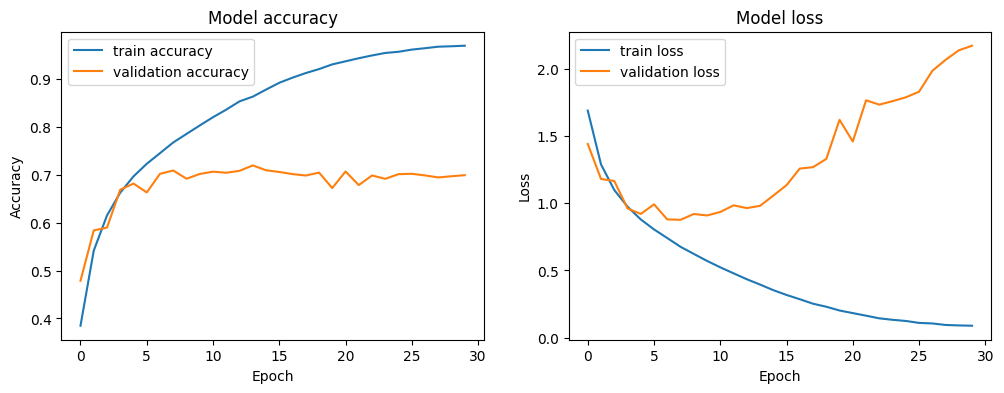

Processing confusion matrix. May take some time...


2024-06-21 08:47:40.898124: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


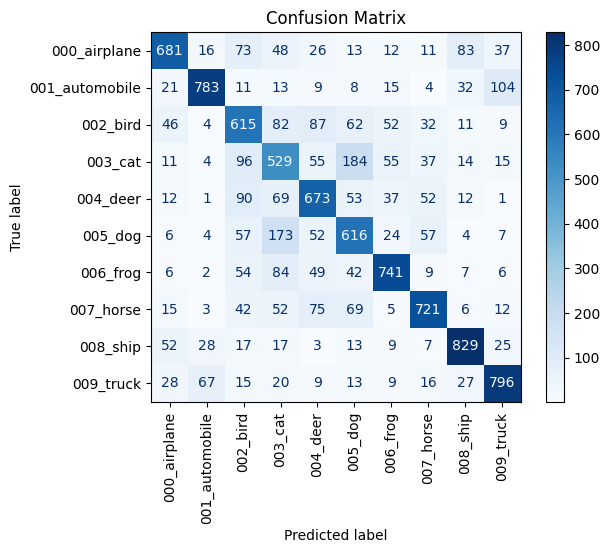

In [ ]:
import tensorflowjs as tfjs

val_loss, val_acc = model.evaluate(test_dataset)
print('val_acc:', val_acc)

model.save(MODELS_DIR+'/ensaio_1.h5')
model.save(MODELS_DIR+'/ensaio_1.keras')
tfjs.converters.save_keras_model(model, 'py8_js_model')

plotLossAccuracy(history)

plotConfusionMatrix(model, test_dataset)

# Interpretação de resultados: Ensaio 1

* Temos duas vertentes distintas que queremos analisar e posteriormente interligar. Primeiramente olhar para o resultado que obtemos em consequencia do treino propriamente dito, em conjunto com os dados de validação e depois outra vertente que é testar o modelo obtido com dados novos, no qual se consegue obter o nível de generalização que o nosso modelo consegue oferecer.
Neste fase inicial vamos dar mais importancia à primeira vertente, mas nunca ignorando a segunda.
Podemos perceber que os valores de accuracy do treino (linha azul) até conseguem uma accuracy muito boa, cerca de 97% e uma loss muito baixa 0.0832, porém, quando confrontado com os dados de validação, conseguimos perceber que o modelo na realidade tem uma fraca capacidade de generalização, porque o resultado da validação apenas consegue um máximo de "accuracy" próximo de 70%. Este resultados podem ser comprovado pelos graficos acima, que mostra claramente que a validação , em determinado momento estagnou, e nao aconmpanhou os valores obtidos pelo treino.
* Estes graficos apresentam um desenho que sugerem que o modelo entrou em overfitting a partir da epoch 5, e nesse momento deixou de aprender e começou a memorizar as imagens de treino.
* Em relação à vertente 2 do problema, utlizamos a função "evaluate" que vai avaliar o modelo, utilizando dados de teste, que comprovou que o nosso modelo precisa de ser melhorado para obter uma generalização melhor, porque apenas apresentou uma accuracy de cerca de 68% e um loss de cerca de 2.46.
* Daqui para a frente vamos-nos basear no resultado dos dados de teste como métrica de referencia e comparação, e assim decidir o grau de satisfação do modelo treinado, porque acabam por ser valores altamente fiaveis, porque são utilizadas amostras novas, que o modelo não conhece
* A matriz de confusão apresenta a indicação clara de que o modelo neste momento já está algo satisfatório na medida em que, foi o primeiro ensaio e mesmo que ainda existam demasiados falsos positivos e falsos negativos, não são assim tão significativos em relação aos verdadeiros. Mesmo assim o modelo precisa de ser melhorado para ter uma utilização/generalização eficiente. Por exemplo a classificação dos "cats" precisa de ser melhorado

# Decisões

* Podemos justificar este overfitting por eventualmente não termos um dataset suficientemente grande e estarmos a utilizar uma arquitetura com demasiados neurórios. Vamos tentar melhor o nosso modelo, sabendo que neste momento está num estado de overfitting.
* Existem várias abordagens para mitigar o overfitting, e para já vamos incluir no processo de treino o data augmentation, que vai permitir aumentar o nosso dataset e incluir também o dropout, que vai possibilitar ajustar/desativar os neuronios utilizados da arquitetura.
* Vamos também introduzir uma funcao callback ao processo de treino que possibilita nao termos que correr as epochs todas (earlystopping), neste 30, quando o modelo entras em overfitting. No exemplo anterior, nao seria necessário correr 30 epochs, quando a partir da epoch 5 dá para perceber que o modelo deixa de estar a aprender.
* Com esta funçaõ callback, também, gravamos o ultimo melhor model, quando este começa a piorar.
* Assim podemos aumentar o numero de epochs para 200, em vez de 30, porque temos o earlystopping, configura para terminar após 5 epochs sem melhorias.


---
---

Ensaio #2

---
---

**Data Augmentation utilizado**

2024-06-21 08:47:41.136495: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


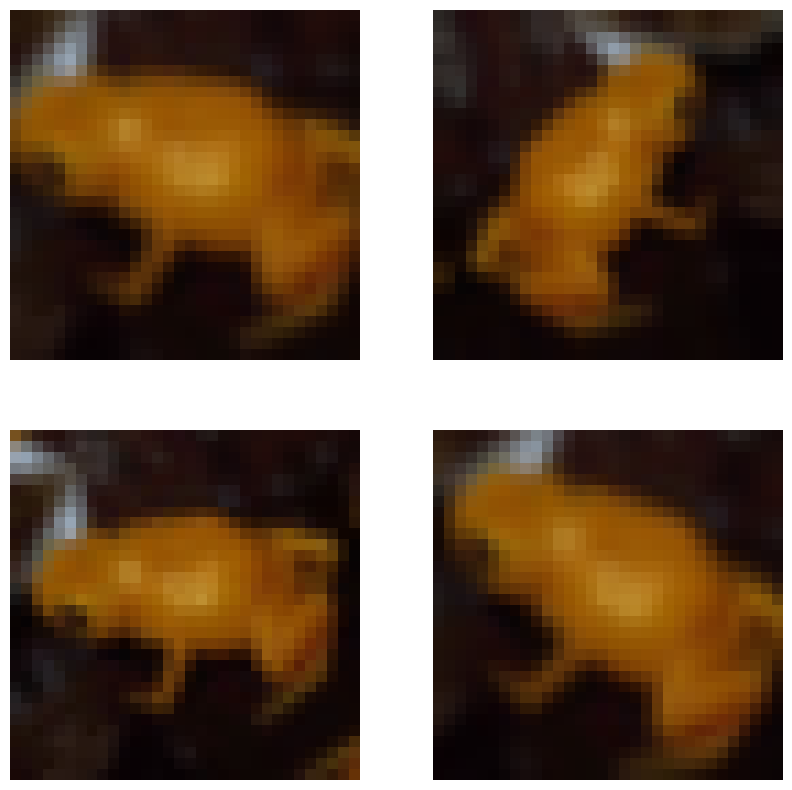

In [ ]:
data_augmentation = keras.Sequential([
layers.RandomFlip("horizontal"),
layers.RandomRotation(0.1), # talvez seja pouca rotação dado o tamanho das imagens do dataset
layers.RandomZoom(0.2), # talvez não seja o mais apropriado dado o tamanho das imagens do dataset
])

plotDataAugmentationImagee(train_dataset, data_augmentation)

Model: "functional_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_8 (InputLayer)      │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_4 (Sequential)       │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_4 (Rescaling)         │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 30, 30, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 15, 15, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 13, 13, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 4, 4, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 10)             │        20,490 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 113,738 (444.29 KB)

 Trainable params: 113,738 (444.29 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/200
625/625 ━━━━━━━━━━━━━━━━━━━━ 16s 25ms/step - accuracy: 0.2536 - loss: 2.0104 - val_accuracy: 0.4743 - val_loss: 1.4868
Epoch 2/200
625/625 ━━━━━━━━━━━━━━━━━━━━ 19s 30ms/step - accuracy: 0.4284 - loss: 1.5796 - val_accuracy: 0.5029 - val_loss: 1.4342
Epoch 3/200
625/625 ━━━━━━━━━━━━━━━━━━━━ 18s 29ms/step - accuracy: 0.4881 - loss: 1.4335 - val_accuracy: 0.5572 - val_loss: 1.2508
Epoch 4/200
625/625 ━━━━━━━━━━━━━━━━━━━━ 17s 26ms/step - accuracy: 0.5196 - loss: 1.3535 - val_accuracy: 0.5889 - val_loss: 1.1598
Epoch 5/200
625/625 ━━━━━━━━━━━━━━━━━━━━ 16s 26ms/step - accuracy: 0.5447 - loss: 1.2904 - val_accuracy: 0.5533 - val_loss: 1.3533
Epoch 6/200
625/625 ━━━━━━━━━━━━━━━━━━━━ 16s 26ms/step - accuracy: 0.5622 - loss: 1.2444 - val_accuracy: 0.6069 - val_loss: 1.1115
Epoch 7/200
625/625 ━━━━━━━━━━━━━━━━━━━━ 17s 27ms/step - accuracy: 0.5711 - loss: 1.2070 - val_accuracy: 0.6178 - val_loss: 1.1046
Epoch 8/200
625/625 ━━━━━━━━━━━━━━━━━━━━ 16s 26ms/step - accuracy: 0.5871 - loss: 1

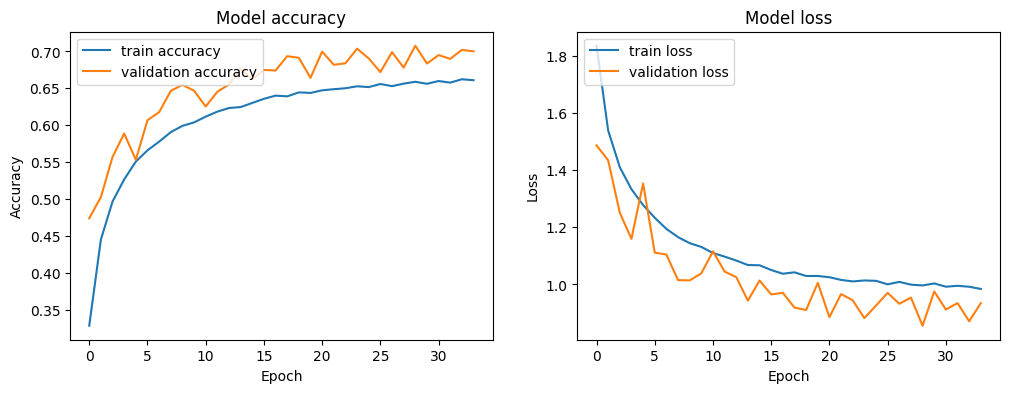

Processing confusion matrix. May take some time...


2024-06-21 08:57:13.137963: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


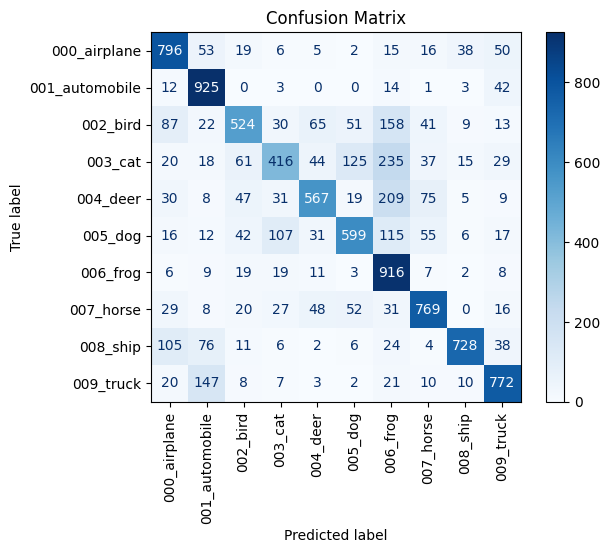

In [ ]:
# Ensaio 2
NUMBER_OF_EPOCHS=200
LEARNING_RATE=0.001

from tensorflow import keras
from keras import layers

data_augmentation = keras.Sequential([
layers.RandomFlip("horizontal"),
layers.RandomRotation(0.1),
layers.RandomZoom(0.2),
])

callbacks_list = [
    keras.callbacks.EarlyStopping(monitor="val_accuracy",patience=5),
    keras.callbacks.ModelCheckpoint(filepath="checkpoint_path.keras",monitor="val_loss",save_best_only=True),
]

inputs = keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
x = data_augmentation(inputs)
x = layers.Rescaling(1. / 255)(x)
x = layers.Conv2D(32, 3, activation='relu')(x)
x = layers.MaxPooling2D()(x)
x = layers.Conv2D(64, 3, activation='relu')(x)
x = layers.MaxPooling2D()(x)
x = layers.Conv2D(128, 3, activation='relu')(x)
x = layers.Flatten()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(10, activation='softmax')(x)

model = keras.Model(inputs, outputs)
model.summary()
model.compile(optimizer=keras.optimizers.RMSprop(learning_rate=LEARNING_RATE),loss="sparse_categorical_crossentropy",metrics=["accuracy"])
history = model.fit(train_dataset, epochs=NUMBER_OF_EPOCHS, validation_data=validation_dataset, callbacks=callbacks_list)

val_loss, val_acc = model.evaluate(test_dataset)
print('val_acc:', val_acc)
plotLossAccuracy(history)
plotConfusionMatrix(model, test_dataset)


In [ ]:
#model.save(MODELS_DIR+'/ensaio_2.h5')
model.save(MODELS_DIR+'/ensaio_2.keras')

# Interpretação de resultados: Ensaio 2

* O callback "earlystopping" funcionou de uma forma bastante eficaz e permitiu treinar o modelo em 31 epochs, terminando e gravando a versao com melhor loss (ModelCheckpoint).

* Analisando os resultados, podemos perceber que existe uma mitigação muito boa do overfitness, na medida em que, embora a accuracy de treino tenha descido, dá para perceber que , nas 21 epochs de treino tivemos uma boa melhoria na accuracy de teste, cerca de 68% e uma loss de teste inferior de cerca de 0.94
* Mesmo assim a expetativa era maior, porque utilizando o data-augmentation, deveriamos conseguir obter um dataset muito maior, e consequentemente permitir correr uma aprendizagem mais completa a assim melhorar o modelo tornando-o mais robusto

* Isto significa que o data augmentation teve o resultado inverso ao esperado
* Pela analise da matrix de confusao temos, por exemplo muitos mais "cats" mal classificados como "dogs" e muitos "dears" mal classificados como "horses", como consequencia da utilização do data-augmentation, o que mostra que o tamanho reduzido das imagens de treino pode ser a causa deste resultado inesperado
* Por outro lado o dropout veio trazer uma significativa mitigação do overfitting.


* Vamos analisar algumas das imagens, geradas pelo data augmentation para confirmar que as alterações das imagens foram feitas corretamente
* Imprimindo as imagens adicionadas poderemos tentar perceber quais as melhores configurações a usar, sabendo que estamos a utilizar imagens pequenas, com muito menos detalhe, e, por exemplo, o RandomZoom não nos parece ser uma boa opção, porque vai tornar as imagens pequenas ainda mais pequenos. Assim não vamos utilizar essa funcao, e vamos explorar outras, que não foram dados na aula, mas que são perfeitamnete aplicáveis neste contexto
* Como as imagens do dataset sao pequenas, também decidimos usar um valor de rotação maior (0.7), fazendo com que as imagens nao sejam consideradas iguais durante a aprendizagem do modelo
* A utilização do contraste também nos parece uma boa alternativa porque irá objetvamente alterar a imagem original, dado que estamos a usar um imagens de 3 canais (3 cores, RGB), e esta função vai ter impacto neste valores.

2024-06-21 08:57:13.436053: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


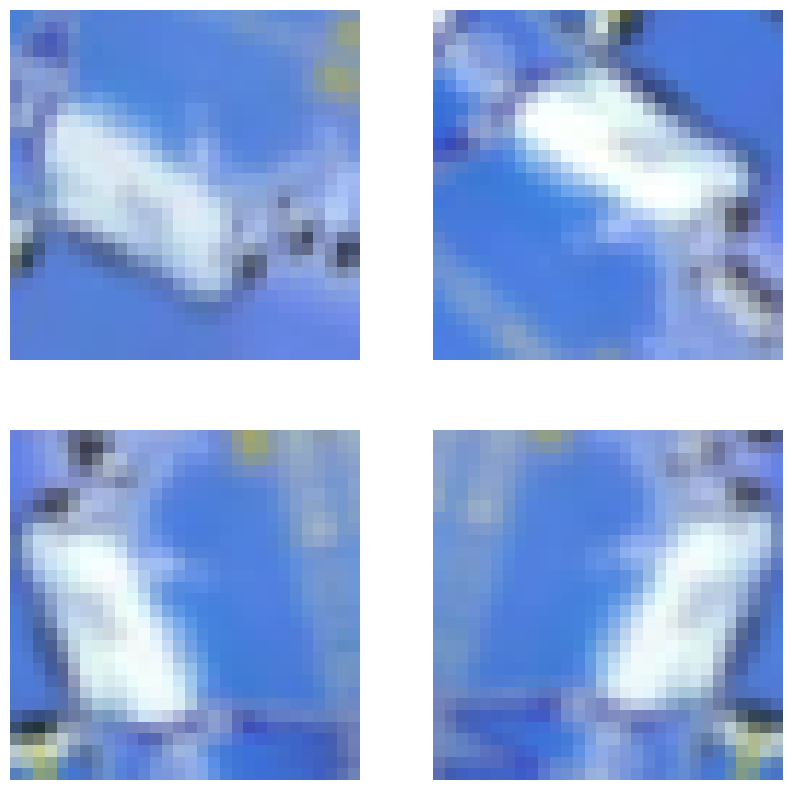

In [ ]:
data_augmentation = keras.Sequential([
layers.RandomFlip("horizontal"),
layers.RandomCrop(30,30),
layers.RandomTranslation(height_factor=0.1, width_factor=0.1),
layers.RandomContrast(0.2),
layers.RandomRotation(0.7),
])

plotDataAugmentationImagee(train_dataset, data_augmentation)

2024-06-21 08:57:13.555740: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


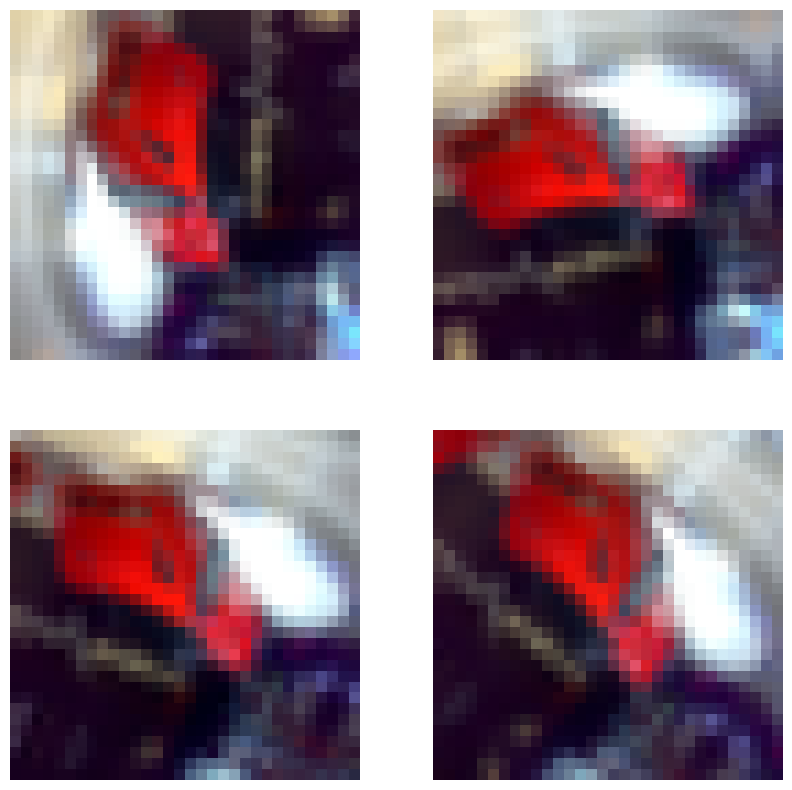

In [ ]:
data_augmentation = keras.Sequential([
layers.RandomFlip("horizontal"),
layers.RandomContrast(0.2),
layers.RandomRotation(0.7),
])

plotDataAugmentationImagee(train_dataset, data_augmentation)

# Decisões
* Após alguns ensaios visuais, decidimos treinar 2 modelos, cada um com 2 diferentes configurações de data-augmentation:
* Uma com
```
layers.RandomFlip("horizontal"),
layers.RandomContrast(0.2),
layers.RandomRotation(0.7),
```
* E outra com
```
layers.RandomFlip("horizontal"),
layers.RandomCrop(30,30),
layers.RandomTranslation(height_factor=0.1, width_factor=0.1),
layers.RandomContrast(0.2),
layers.RandomRotation(0.7),
```



---
---

Ensaio #3.1

---
---

Model: "functional_19"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_12 (InputLayer)     │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_7 (Sequential)       │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_5 (Rescaling)         │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 30, 30, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 15, 15, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_16 (Conv2D)              │ (None, 13, 13, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 4, 4, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 10)             │        20,490 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 113,738 (444.29 KB)

 Trainable params: 113,738 (444.29 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/200
625/625 ━━━━━━━━━━━━━━━━━━━━ 15s 23ms/step - accuracy: 0.2679 - loss: 1.9904 - val_accuracy: 0.4209 - val_loss: 1.5659
Epoch 2/200
625/625 ━━━━━━━━━━━━━━━━━━━━ 15s 24ms/step - accuracy: 0.4279 - loss: 1.5815 - val_accuracy: 0.4983 - val_loss: 1.4409
Epoch 3/200
625/625 ━━━━━━━━━━━━━━━━━━━━ 15s 24ms/step - accuracy: 0.4852 - loss: 1.4474 - val_accuracy: 0.5513 - val_loss: 1.2724
Epoch 4/200
625/625 ━━━━━━━━━━━━━━━━━━━━ 15s 24ms/step - accuracy: 0.5207 - loss: 1.3623 - val_accuracy: 0.5945 - val_loss: 1.1502
Epoch 5/200
625/625 ━━━━━━━━━━━━━━━━━━━━ 15s 24ms/step - accuracy: 0.5398 - loss: 1.2916 - val_accuracy: 0.5725 - val_loss: 1.2331
Epoch 6/200
625/625 ━━━━━━━━━━━━━━━━━━━━ 15s 24ms/step - accuracy: 0.5589 - loss: 1.2495 - val_accuracy: 0.6078 - val_loss: 1.1117
Epoch 7/200
625/625 ━━━━━━━━━━━━━━━━━━━━ 15s 24ms/step - accuracy: 0.5781 - loss: 1.2123 - val_accuracy: 0.6281 - val_loss: 1.0552
Epoch 8/200
625/625 ━━━━━━━━━━━━━━━━━━━━ 15s 24ms/step - accuracy: 0.5908 - loss: 1

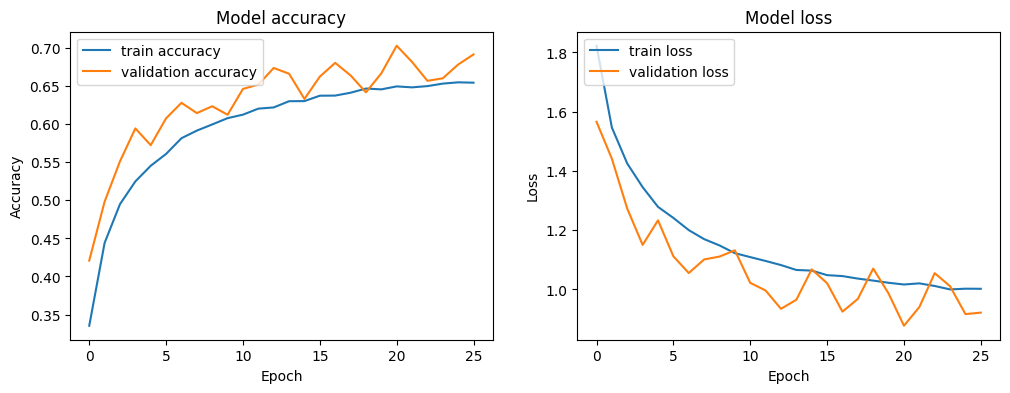

Processing confusion matrix. May take some time...


2024-06-21 09:03:47.310582: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


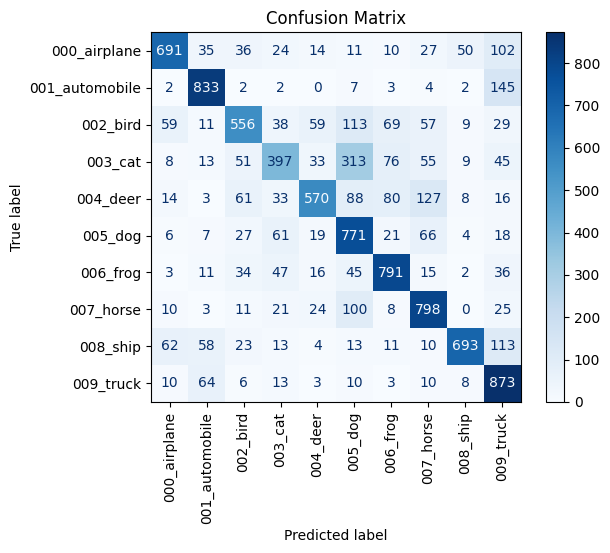

In [ ]:
# Ensaio 3.1
NUMBER_OF_EPOCHS=200
LEARNING_RATE=0.001

from tensorflow import keras
from keras import layers

data_augmentation = keras.Sequential([
layers.RandomFlip("horizontal"),
layers.RandomRotation(0.1),
layers.RandomZoom(0.2),
])

callbacks_list = [
    keras.callbacks.EarlyStopping(monitor="val_accuracy",patience=5),
    keras.callbacks.ModelCheckpoint(filepath="checkpoint_path.keras",monitor="val_loss",save_best_only=True),
]

inputs = keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
x = data_augmentation(inputs)
x = layers.Rescaling(1. / 255)(x)
x = layers.Conv2D(32, 3, activation='relu')(x)
x = layers.MaxPooling2D()(x)
x = layers.Conv2D(64, 3, activation='relu')(x)
x = layers.MaxPooling2D()(x)
x = layers.Conv2D(128, 3, activation='relu')(x)
x = layers.Flatten()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(10, activation='softmax')(x)

model = keras.Model(inputs, outputs)
model.summary()
model.compile(optimizer=keras.optimizers.RMSprop(learning_rate=LEARNING_RATE),loss="sparse_categorical_crossentropy",metrics=["accuracy"])
history = model.fit(train_dataset, epochs=NUMBER_OF_EPOCHS, validation_data=validation_dataset, callbacks=callbacks_list)

val_loss, val_acc = model.evaluate(test_dataset)
print('val_acc:', val_acc)
plotLossAccuracy(history)
plotConfusionMatrix(model, test_dataset)

In [ ]:
#model.save(MODELS_DIR+'/ensaio_3_1.h5')
model.save(MODELS_DIR+'/ensaio_3_1.keras')


---
---

Ensaio #3.2

---
---

Model: "functional_22"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_14 (InputLayer)     │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_8 (Sequential)       │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_6 (Rescaling)         │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_18 (Conv2D)              │ (None, 30, 30, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 15, 15, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_19 (Conv2D)              │ (None, 13, 13, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_20 (Conv2D)              │ (None, 4, 4, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_6 (Flatten)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 10)             │        20,490 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 113,738 (444.29 KB)

 Trainable params: 113,738 (444.29 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/200
625/625 ━━━━━━━━━━━━━━━━━━━━ 15s 23ms/step - accuracy: 0.2625 - loss: 2.0058 - val_accuracy: 0.4539 - val_loss: 1.5133
Epoch 2/200
625/625 ━━━━━━━━━━━━━━━━━━━━ 15s 24ms/step - accuracy: 0.4249 - loss: 1.5874 - val_accuracy: 0.5138 - val_loss: 1.3698
Epoch 3/200
625/625 ━━━━━━━━━━━━━━━━━━━━ 15s 24ms/step - accuracy: 0.4862 - loss: 1.4409 - val_accuracy: 0.5474 - val_loss: 1.2794
Epoch 4/200
625/625 ━━━━━━━━━━━━━━━━━━━━ 15s 24ms/step - accuracy: 0.5164 - loss: 1.3580 - val_accuracy: 0.5671 - val_loss: 1.2434
Epoch 5/200
625/625 ━━━━━━━━━━━━━━━━━━━━ 15s 24ms/step - accuracy: 0.5402 - loss: 1.3004 - val_accuracy: 0.6103 - val_loss: 1.1130
Epoch 6/200
625/625 ━━━━━━━━━━━━━━━━━━━━ 15s 24ms/step - accuracy: 0.5582 - loss: 1.2585 - val_accuracy: 0.6059 - val_loss: 1.1436
Epoch 7/200
625/625 ━━━━━━━━━━━━━━━━━━━━ 15s 24ms/step - accuracy: 0.5716 - loss: 1.2118 - val_accuracy: 0.5745 - val_loss: 1.2646
Epoch 8/200
625/625 ━━━━━━━━━━━━━━━━━━━━ 15s 23ms/step - accuracy: 0.5775 - loss: 1

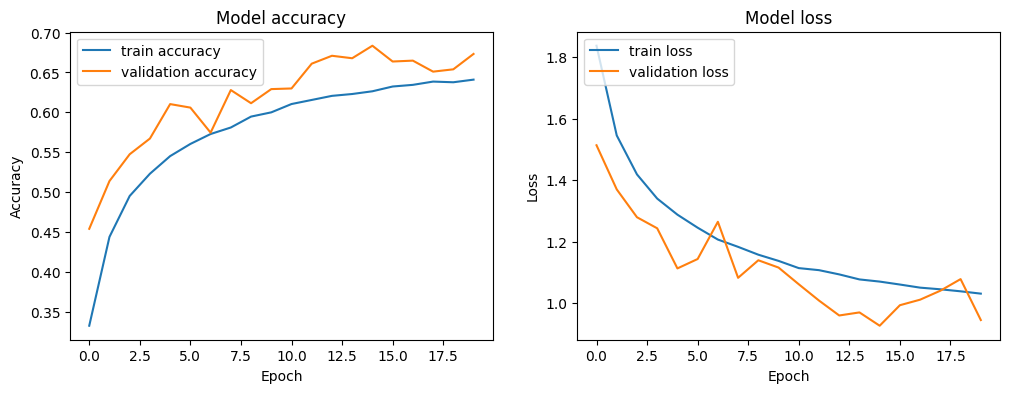

Processing confusion matrix. May take some time...


2024-06-21 09:08:58.558782: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


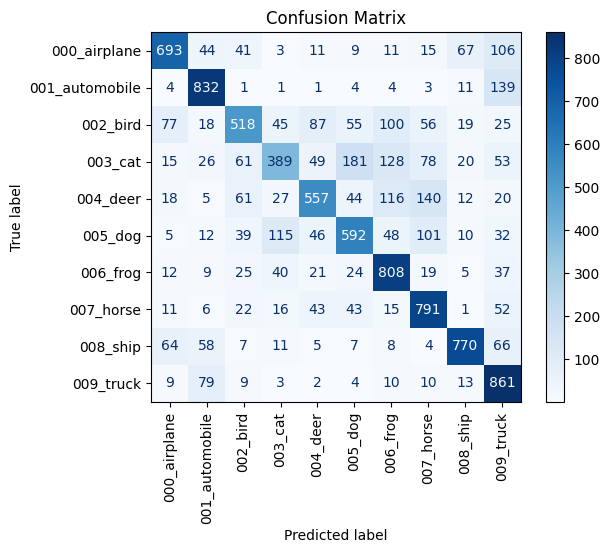

In [ ]:
# Ensaio 3.2
NUMBER_OF_EPOCHS=200
LEARNING_RATE=0.001

from tensorflow import keras
from keras import layers

data_augmentation = keras.Sequential([
layers.RandomFlip("horizontal"),
layers.RandomRotation(0.1),
layers.RandomZoom(0.2),
])

callbacks_list = [
    keras.callbacks.EarlyStopping(monitor="val_accuracy",patience=5),
    keras.callbacks.ModelCheckpoint(filepath="checkpoint_path.keras",monitor="val_loss",save_best_only=True),
]

inputs = keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
x = data_augmentation(inputs)
x = layers.Rescaling(1. / 255)(x)
x = layers.Conv2D(32, 3, activation='relu')(x)
x = layers.MaxPooling2D()(x)
x = layers.Conv2D(64, 3, activation='relu')(x)
x = layers.MaxPooling2D()(x)
x = layers.Conv2D(128, 3, activation='relu')(x)
x = layers.Flatten()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(10, activation='softmax')(x)

model = keras.Model(inputs, outputs)
model.summary()
model.compile(optimizer=keras.optimizers.RMSprop(learning_rate=LEARNING_RATE),loss="sparse_categorical_crossentropy",metrics=["accuracy"])
history = model.fit(train_dataset, epochs=NUMBER_OF_EPOCHS, validation_data=validation_dataset, callbacks=callbacks_list)

val_loss, val_acc = model.evaluate(test_dataset)
print('val_acc:', val_acc)
plotLossAccuracy(history)
plotConfusionMatrix(model, test_dataset)

In [ ]:
#model.save(MODELS_DIR+'/ensaio_3_2.h5')
model.save(MODELS_DIR+'/ensaio_3_2.keras')

# Interpretação de resultados: Ensaio 3.1 e Ensaio 3.2

* Analisando os resultados, podemos perceber que nao houve melhoria.
* Analisando a matrix de confusão também podemos salientar que o existem demasiados falsos positivos. Consegue-se perceber que algumas muitas predições são erradas o que reforça ideia de que o tamanho das imagens pode ser a causa da nao eficacia do data-augmentation que normalmente oferece vantagens
* Este valores mostram que a utilização do data augmentation teve o resultado inverso ao esperado e que as melhorias verificadas em comparação ao ensaio 1 foram provocadas pela utilização do dropout

# Decisões

* Para já vamos focar um pouco mais no dropout
* Foi decidido treinar um modelo sem data augmentation mas mantendo na mesma o dropout
* No próximo ensaio, adicionalmente vamos ntroduzir uma tecnica chamada de BatchNormalization
* BatchNormalization é uma técnica para melhorar o desempenho e a estabilidade da aprendizagem/treino, Esta tecnica aplica uma transformação que mantém o valor medio de saida de cada camada próximo de zero e assim torna também o modelo mais robusto


---
---

Ensaio #4

---
---

Model: "functional_49"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_31 (InputLayer)     │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_18 (Rescaling)        │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_55 (Conv2D)              │ (None, 30, 30, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 30, 30, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_5 (Activation)       │ (None, 30, 30, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_36 (MaxPooling2D) │ (None, 15, 15, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_56 (Conv2D)              │ (None, 13, 13, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 13, 13, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_6 (Activation)       │ (None, 13, 13, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_37 (MaxPooling2D) │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_57 (Conv2D)              │ (None, 4, 4, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 4, 4, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_7 (Activation)       │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_18 (Flatten)            │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 10)             │        20,490 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 114,634 (447.79 KB)

 Trainable params: 114,186 (446.04 KB)

 Non-trainable params: 448 (1.75 KB)

Epoch 1/200
625/625 ━━━━━━━━━━━━━━━━━━━━ 21s 32ms/step - accuracy: 0.4076 - loss: 1.7737 - val_accuracy: 0.5195 - val_loss: 1.3733
Epoch 2/200
625/625 ━━━━━━━━━━━━━━━━━━━━ 20s 33ms/step - accuracy: 0.5998 - loss: 1.1440 - val_accuracy: 0.5645 - val_loss: 1.2586
Epoch 3/200
625/625 ━━━━━━━━━━━━━━━━━━━━ 23s 37ms/step - accuracy: 0.6663 - loss: 0.9596 - val_accuracy: 0.5869 - val_loss: 1.2341
Epoch 4/200
625/625 ━━━━━━━━━━━━━━━━━━━━ 23s 37ms/step - accuracy: 0.6988 - loss: 0.8619 - val_accuracy: 0.6946 - val_loss: 0.8790
Epoch 5/200
625/625 ━━━━━━━━━━━━━━━━━━━━ 22s 35ms/step - accuracy: 0.7215 - loss: 0.7980 - val_accuracy: 0.6861 - val_loss: 0.8998
Epoch 6/200
625/625 ━━━━━━━━━━━━━━━━━━━━ 22s 35ms/step - accuracy: 0.7404 - loss: 0.7474 - val_accuracy: 0.6816 - val_loss: 0.9379
Epoch 7/200
625/625 ━━━━━━━━━━━━━━━━━━━━ 23s 37ms/step - accuracy: 0.7546 - loss: 0.7017 - val_accuracy: 0.6587 - val_loss: 1.0782
Epoch 8/200
625/625 ━━━━━━━━━━━━━━━━━━━━ 22s 36ms/step - accuracy: 0.7698 - loss: 0

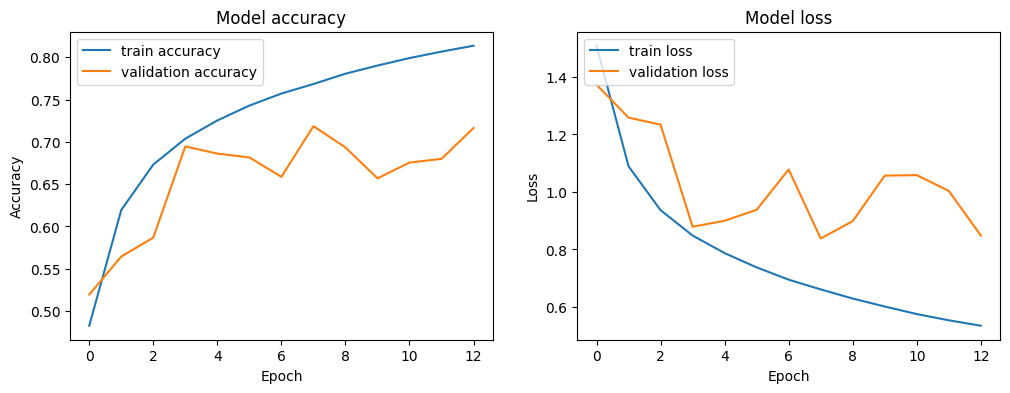

Processing confusion matrix. May take some time...


2024-06-21 12:00:01.046369: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


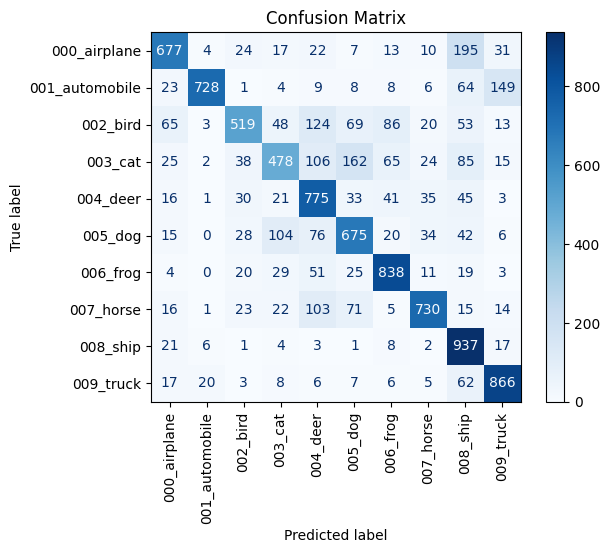

In [ ]:
# Ensaio 4
NUMBER_OF_EPOCHS=200
LEARNING_RATE=0.001

from tensorflow import keras
from keras import layers

callbacks_list = [
    keras.callbacks.EarlyStopping(monitor="val_accuracy",patience=5),
    keras.callbacks.ModelCheckpoint(filepath="checkpoint_path.keras",monitor="val_loss",save_best_only=True),
]

inputs = keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
x = layers.Rescaling(1. / 255)(inputs)
x = layers.Conv2D(32, 3)(x)
x = layers.BatchNormalization()(x)
x = layers.Activation("relu")(x)
x = layers.MaxPooling2D()(x)
x = layers.Conv2D(64, 3)(x)
x = layers.BatchNormalization()(x)
x = layers.Activation("relu")(x)
x = layers.MaxPooling2D()(x)
x = layers.Conv2D(128, 3)(x)
x = layers.BatchNormalization()(x)
x = layers.Activation("relu")(x)
x = layers.Flatten()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(10, activation='softmax')(x)

model = keras.Model(inputs, outputs)
model.summary()
model.compile(optimizer=keras.optimizers.RMSprop(learning_rate=LEARNING_RATE),loss="sparse_categorical_crossentropy",metrics=["accuracy"])
history = model.fit(train_dataset, epochs=NUMBER_OF_EPOCHS, validation_data=validation_dataset, callbacks=callbacks_list)

val_loss, val_acc = model.evaluate(test_dataset)
print('val_acc:', val_acc)
plotLossAccuracy(history)
plotConfusionMatrix(model, test_dataset)

In [ ]:
#model.save(MODELS_DIR+'/ensaio_4.h5')
model.save(MODELS_DIR+'/ensaio_4.keras')

# Interpretação de resultados: Ensaio 4

* Analisando os resultados, podemos perceber que resultados melhoraram em relação ao ensaio anterior. Nas 13 epocas de treino tivemos uma boa melhoria na accuracy de validação, cerca de 72% e uma loss inferior de cerca de 0.86.
* A matriz de confusão, embora já diferente para melhor, mas ainda apresenta a indicação de que existem demasiados falsos negativos e falsos negativos, neste caso a incidir na classificação dos "cats" e "birds"
* Conseguimos neste exemplo evidenciar o fator do BatchNormalization que claramente acelarou a aprendizagem, atingindo o overfitness mais cedo, neste caso em apenas 13 epochs

# Decisões

* O número de neurónios das camadas convolucionais neste momento utilizados são 32, 64 e 128 das 3 camadas.
* Considerando que o dropout vai desativando e ativando neurónios para combater o overfitting, decidimos no próximo ensaio testar e tentar aumentar o número de neurónios na várias camadas desta arquitetura, para ver até que ponto conseguiriamos torna-los mais robusto e flexivel com utilização do dropout
* Decidimos, para já não utilizar o BatchNormalization, explorando outra tecnicas, mas sempre com a intenção de voltar a aplicar esta tecnica num estagio mais avança, e nesse altura avaliar a sua inclusão no modelo final



---
---

Ensaio #5

---
---

Model: "functional_26"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_17 (InputLayer)     │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_8 (Rescaling)         │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_24 (Conv2D)              │ (None, 30, 30, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_16 (MaxPooling2D) │ (None, 15, 15, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_25 (Conv2D)              │ (None, 13, 13, 256)    │        73,984 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_17 (MaxPooling2D) │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_26 (Conv2D)              │ (None, 4, 4, 64)       │       147,520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_8 (Flatten)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 64)             │        65,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 288,650 (1.10 MB)

 Trainable params: 288,650 (1.10 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/200
625/625 ━━━━━━━━━━━━━━━━━━━━ 26s 41ms/step - accuracy: 0.2627 - loss: 1.9871 - val_accuracy: 0.4868 - val_loss: 1.4174
Epoch 2/200
625/625 ━━━━━━━━━━━━━━━━━━━━ 26s 41ms/step - accuracy: 0.4896 - loss: 1.4203 - val_accuracy: 0.5496 - val_loss: 1.2467
Epoch 3/200
625/625 ━━━━━━━━━━━━━━━━━━━━ 26s 42ms/step - accuracy: 0.5658 - loss: 1.2339 - val_accuracy: 0.6239 - val_loss: 1.0669
Epoch 4/200
625/625 ━━━━━━━━━━━━━━━━━━━━ 26s 41ms/step - accuracy: 0.6181 - loss: 1.0937 - val_accuracy: 0.6266 - val_loss: 1.0549
Epoch 5/200
625/625 ━━━━━━━━━━━━━━━━━━━━ 26s 42ms/step - accuracy: 0.6471 - loss: 1.0124 - val_accuracy: 0.6717 - val_loss: 0.9443
Epoch 6/200
625/625 ━━━━━━━━━━━━━━━━━━━━ 26s 42ms/step - accuracy: 0.6711 - loss: 0.9433 - val_accuracy: 0.6688 - val_loss: 0.9445
Epoch 7/200
625/625 ━━━━━━━━━━━━━━━━━━━━ 26s 42ms/step - accuracy: 0.6888 - loss: 0.8944 - val_accuracy: 0.7029 - val_loss: 0.8684
Epoch 8/200
625/625 ━━━━━━━━━━━━━━━━━━━━ 26s 42ms/step - accuracy: 0.6991 - loss: 0

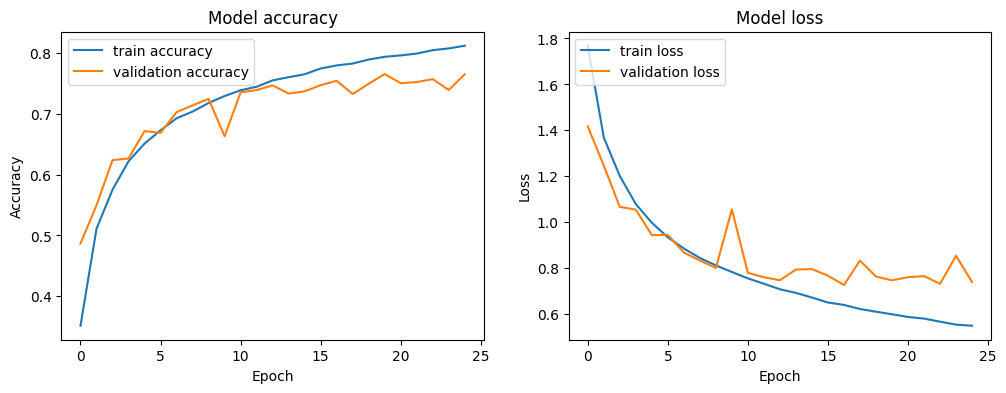

Processing confusion matrix. May take some time...


2024-06-21 09:55:18.370790: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


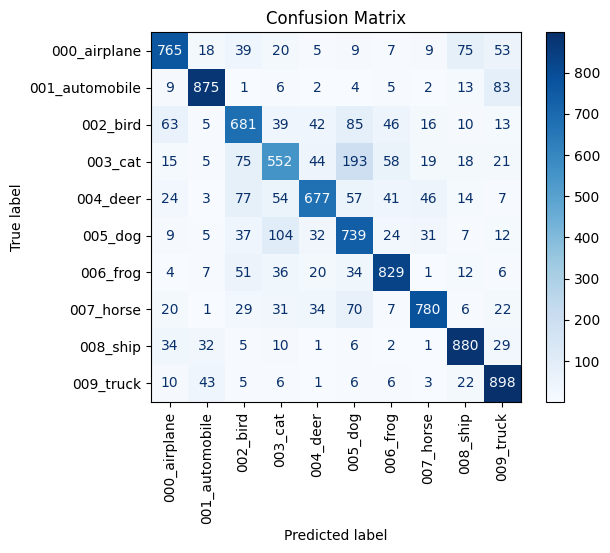

In [ ]:
# Ensaio 5
NUMBER_OF_EPOCHS=200
LEARNING_RATE=0.001

from tensorflow import keras
from keras import layers

callbacks_list = [
    keras.callbacks.EarlyStopping(monitor="val_accuracy",patience=5),
    keras.callbacks.ModelCheckpoint(filepath="checkpoint_path.keras",monitor="val_loss",save_best_only=True),
]

inputs = keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
x = layers.Rescaling(1. / 255)(inputs)
x = layers.Conv2D(32, 3, activation='relu')(x)
x = layers.MaxPooling2D()(x)
x = layers.Conv2D(256, 3, activation='relu')(x)
x = layers.MaxPooling2D()(x)
x = layers.Conv2D(64, 3, activation='relu')(x)
x = layers.Flatten()(x)
x = layers.Dropout(0.6)(x)
x = layers.Dense(64, activation='relu')(x)
outputs = layers.Dense(10, activation='softmax')(x)

model = keras.Model(inputs, outputs)
model.summary()
model.compile(optimizer=keras.optimizers.RMSprop(learning_rate=LEARNING_RATE),loss="sparse_categorical_crossentropy",metrics=["accuracy"])
history = model.fit(train_dataset, epochs=NUMBER_OF_EPOCHS, validation_data=validation_dataset, callbacks=callbacks_list)

val_loss, val_acc = model.evaluate(test_dataset)
print('val_acc:', val_acc)
plotLossAccuracy(history)
plotConfusionMatrix(model, test_dataset)

In [ ]:
#model.save(MODELS_DIR+'/ensaio_5.h5')
model.save(MODELS_DIR+'/ensaio_5.keras')

# Interpretação de resultados: Ensaio 5

* Após ir variando a quantidade de neurónios, a solução que apresentou melhor accuracy, embora com pouca melhoria foi camadas convolucionais de 32, 256, 64 em cada camada respetivamente e a adição de uma camada de classificação de 64 neurónios.
* Assim como resultado dos resultados de teste estamos com uma "accuracy" de cerca de 76% e uma loss de cerca de 0.75.
* Foram também testados vários rates de dropout. Utilizando um rate do dropout 0.6, permitiu valores de loss ligeiramente inferiores.
* A matriz de confusão, embora já diferente, mas ainda apresenta a indicação de que existem demasiados falsos positivos e falsos negativos, nomeadamente a troca de "dogs" por "cats"


# Decisões

* Estando a nossa arquitetura estabilizada vamos introdozir outras tecnicas de mitigação de overfitting, nomeadamente tecnicas de regularização L1 e L2. Estas tecnicas sao muito uteis em sistema complexos e grande que permitem de alguma forma simplificar esses modelos, reduzindo a entropia. Estas tecnicas ajustam os peso, usando "penalties" nos parametros das camadas para estes ficarem equilibrados entre eles. Este processo é concretizado adicionando a respectiva funcao callback no processo de treino. A diferença entre o L1 e o L2 é o calculo utilizado para o proceso da reguralização dos pesos.


---
---

Ensaio #6.1 (Regulizers L1)

---
---

Model: "functional_28"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_18 (InputLayer)     │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_9 (Rescaling)         │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_27 (Conv2D)              │ (None, 30, 30, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_18 (MaxPooling2D) │ (None, 15, 15, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_28 (Conv2D)              │ (None, 13, 13, 256)    │        73,984 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_19 (MaxPooling2D) │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_29 (Conv2D)              │ (None, 4, 4, 64)       │       147,520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_9 (Flatten)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 10)             │        10,250 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 232,650 (908.79 KB)

 Trainable params: 232,650 (908.79 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/200
625/625 ━━━━━━━━━━━━━━━━━━━━ 28s 43ms/step - accuracy: 0.1031 - loss: 3723.9856 - val_accuracy: 0.0983 - val_loss: 1162.2461
Epoch 2/200
625/625 ━━━━━━━━━━━━━━━━━━━━ 27s 43ms/step - accuracy: 0.0984 - loss: 719.7116 - val_accuracy: 0.0976 - val_loss: 4.3116
Epoch 3/200
625/625 ━━━━━━━━━━━━━━━━━━━━ 27s 43ms/step - accuracy: 0.0992 - loss: 4.1503 - val_accuracy: 0.0976 - val_loss: 3.9826
157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.1041 - loss: 3.9826
val_acc: 0.10000000149011612


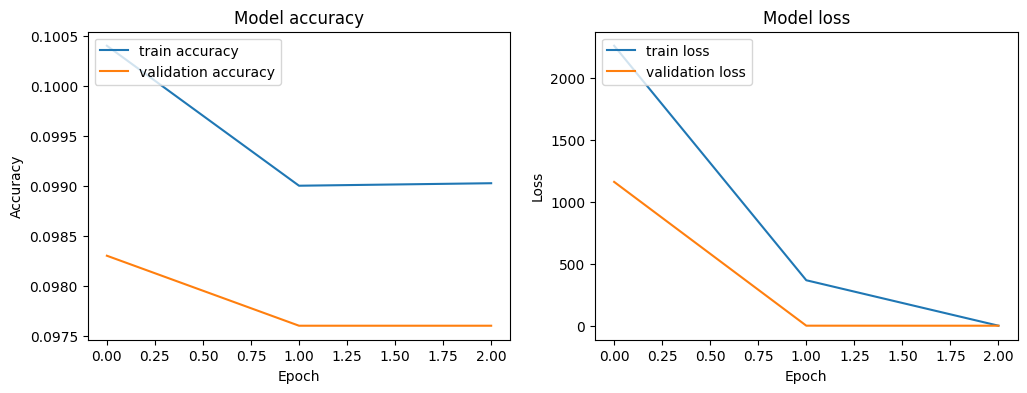

Processing confusion matrix. May take some time...


2024-06-21 09:56:47.850317: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


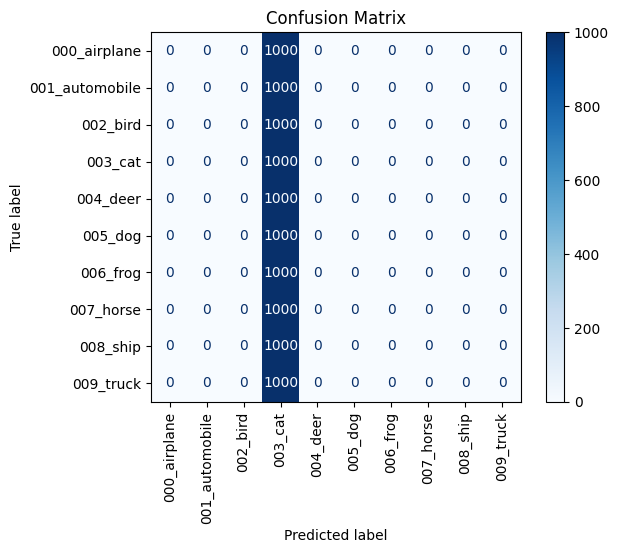

In [ ]:
# Ensaio 6.1
NUMBER_OF_EPOCHS=200
LEARNING_RATE=0.001

from tensorflow import keras
from keras import layers
from keras import regularizers

callbacks_list = [
    keras.callbacks.EarlyStopping(monitor="val_accuracy",patience=2),
    keras.callbacks.ModelCheckpoint(filepath="checkpoint_path.keras",monitor="val_loss",save_best_only=True),
]

inputs = keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
x = layers.Rescaling(1. / 255)(inputs)
x = layers.Conv2D(32, 3, activation='relu')(x)
x = layers.MaxPooling2D()(x)
x = layers.Conv2D(256, 3, activation='relu',kernel_regularizer='l1')(x)
x = layers.MaxPooling2D()(x)
x = layers.Conv2D(64, 3, activation='relu',
kernel_initializer='ones',
kernel_regularizer=regularizers.l1(0.02),
activity_regularizer=regularizers.l1(0.02),
bias_regularizer=regularizers.l1(0.02))(x)
x = layers.Flatten()(x)
x = layers.Dropout(0.6)(x)
outputs = layers.Dense(10, activation='softmax')(x)


model = keras.Model(inputs, outputs)
model.summary()
model.compile(optimizer=keras.optimizers.RMSprop(learning_rate=LEARNING_RATE),loss="sparse_categorical_crossentropy",metrics=["accuracy"])
history = model.fit(train_dataset, epochs=NUMBER_OF_EPOCHS, validation_data=validation_dataset, callbacks=callbacks_list)

val_loss, val_acc = model.evaluate(test_dataset)
print('val_acc:', val_acc)
plotLossAccuracy(history)
plotConfusionMatrix(model, test_dataset)

In [ ]:
#model.save(MODELS_DIR+'/ensaio_6_1.h5')
model.save(MODELS_DIR+'/ensaio_6_1.keras')


---
---

Ensaio #6.2 (Regulizers L2)

---
---

Model: "functional_31"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_19 (InputLayer)     │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_9 (Sequential)       │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_10 (Rescaling)        │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_30 (Conv2D)              │ (None, 30, 30, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_20 (MaxPooling2D) │ (None, 15, 15, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_31 (Conv2D)              │ (None, 13, 13, 256)    │        73,984 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_21 (MaxPooling2D) │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_32 (Conv2D)              │ (None, 4, 4, 64)       │       147,520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_10 (Flatten)            │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 64)             │        65,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 288,650 (1.10 MB)

 Trainable params: 288,650 (1.10 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/200
625/625 ━━━━━━━━━━━━━━━━━━━━ 29s 45ms/step - accuracy: 0.1989 - loss: 2.3516 - val_accuracy: 0.3145 - val_loss: 1.9111
Epoch 2/200
625/625 ━━━━━━━━━━━━━━━━━━━━ 28s 45ms/step - accuracy: 0.3027 - loss: 1.9502 - val_accuracy: 0.3293 - val_loss: 1.9100
Epoch 3/200
625/625 ━━━━━━━━━━━━━━━━━━━━ 28s 45ms/step - accuracy: 0.3571 - loss: 1.8269 - val_accuracy: 0.4060 - val_loss: 1.6955
Epoch 4/200
625/625 ━━━━━━━━━━━━━━━━━━━━ 28s 45ms/step - accuracy: 0.3833 - loss: 1.7635 - val_accuracy: 0.4357 - val_loss: 1.6240
Epoch 5/200
625/625 ━━━━━━━━━━━━━━━━━━━━ 28s 44ms/step - accuracy: 0.4051 - loss: 1.7227 - val_accuracy: 0.4448 - val_loss: 1.5952
Epoch 6/200
625/625 ━━━━━━━━━━━━━━━━━━━━ 28s 44ms/step - accuracy: 0.4167 - loss: 1.6954 - val_accuracy: 0.4586 - val_loss: 1.5776
Epoch 7/200
625/625 ━━━━━━━━━━━━━━━━━━━━ 28s 45ms/step - accuracy: 0.4260 - loss: 1.6712 - val_accuracy: 0.4605 - val_loss: 1.5721
Epoch 8/200
625/625 ━━━━━━━━━━━━━━━━━━━━ 28s 44ms/step - accuracy: 0.4389 - loss: 1

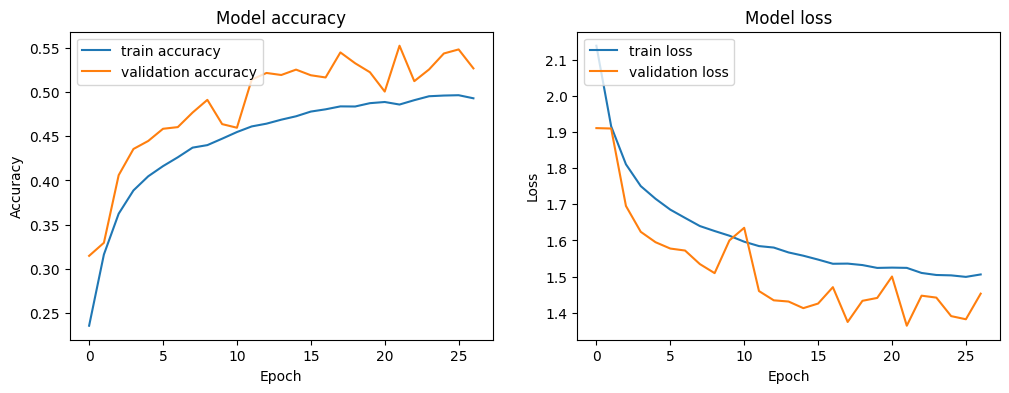

Processing confusion matrix. May take some time...


2024-06-21 10:17:26.679141: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


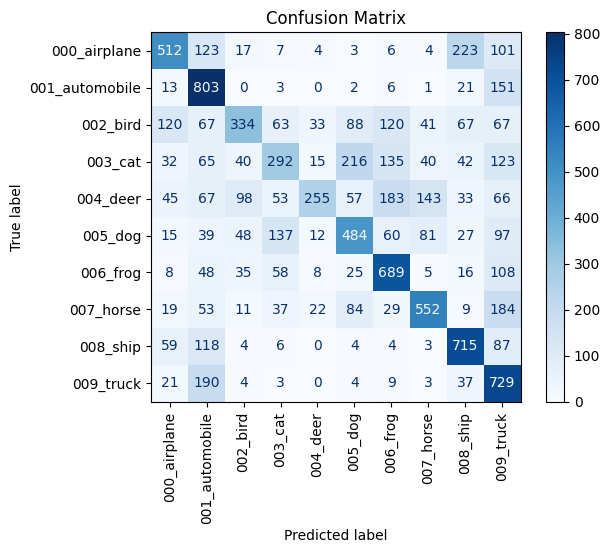

In [ ]:
# Ensaio 6.2
NUMBER_OF_EPOCHS=200
LEARNING_RATE=0.001

from tensorflow import keras
from keras import layers
from keras import regularizers



data_augmentation = keras.Sequential([
layers.RandomFlip("horizontal"),
layers.RandomRotation(0.1),
layers.RandomZoom(0.2),
])

callbacks_list = [
    keras.callbacks.EarlyStopping(monitor="val_accuracy",patience=5),
    keras.callbacks.ModelCheckpoint(filepath="checkpoint_path.keras",monitor="val_loss",save_best_only=True),
]

inputs = keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
x = data_augmentation(inputs)
x = layers.Rescaling(1. / 255)(x)
x = layers.Conv2D(32, 3, activation='relu', kernel_regularizer='l2')(x)
x = layers.MaxPooling2D()(x)
x = layers.Conv2D(256, 3, activation='relu',kernel_regularizer='l2')(x)
x = layers.MaxPooling2D()(x)
x = layers.Conv2D(64, 3, activation='relu',kernel_regularizer='l2')(x)
x = layers.Flatten()(x)
x = layers.Dropout(0.6)(x)
x = layers.Dense(64, activation='relu')(x)
outputs = layers.Dense(10, activation='softmax')(x)

model = keras.Model(inputs, outputs)
model.summary()
model.compile(optimizer=keras.optimizers.RMSprop(learning_rate=LEARNING_RATE),loss="sparse_categorical_crossentropy",metrics=["accuracy"])
history = model.fit(train_dataset, epochs=NUMBER_OF_EPOCHS, validation_data=validation_dataset, callbacks=callbacks_list)

val_loss, val_acc = model.evaluate(test_dataset)
print('val_acc:', val_acc)
plotLossAccuracy(history)
plotConfusionMatrix(model, test_dataset)

In [ ]:
#model.save(MODELS_DIR+'/ensaio_6_2.h5')
model.save(MODELS_DIR+'/ensaio_6_2.keras')


---
---

Ensaio #6.3 (L1 e L2 em simultaneo)

---
---

Model: "functional_33"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_21 (InputLayer)     │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_11 (Rescaling)        │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_33 (Conv2D)              │ (None, 30, 30, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_22 (MaxPooling2D) │ (None, 15, 15, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_34 (Conv2D)              │ (None, 13, 13, 256)    │        73,984 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_23 (MaxPooling2D) │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_35 (Conv2D)              │ (None, 4, 4, 64)       │       147,520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_11 (Flatten)            │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 64)             │        65,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 288,650 (1.10 MB)

 Trainable params: 288,650 (1.10 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/200
625/625 ━━━━━━━━━━━━━━━━━━━━ 27s 43ms/step - accuracy: 0.2686 - loss: 1.9555 - val_accuracy: 0.4838 - val_loss: 1.4364
Epoch 2/200
625/625 ━━━━━━━━━━━━━━━━━━━━ 27s 43ms/step - accuracy: 0.4927 - loss: 1.4172 - val_accuracy: 0.5592 - val_loss: 1.2490
Epoch 3/200
625/625 ━━━━━━━━━━━━━━━━━━━━ 27s 44ms/step - accuracy: 0.5693 - loss: 1.2209 - val_accuracy: 0.5759 - val_loss: 1.2267
Epoch 4/200
625/625 ━━━━━━━━━━━━━━━━━━━━ 27s 43ms/step - accuracy: 0.6170 - loss: 1.0967 - val_accuracy: 0.6326 - val_loss: 1.0382
Epoch 5/200
625/625 ━━━━━━━━━━━━━━━━━━━━ 29s 47ms/step - accuracy: 0.6500 - loss: 1.0041 - val_accuracy: 0.6856 - val_loss: 0.9032
Epoch 6/200
625/625 ━━━━━━━━━━━━━━━━━━━━ 28s 45ms/step - accuracy: 0.6734 - loss: 0.9316 - val_accuracy: 0.6852 - val_loss: 0.9098
Epoch 7/200
625/625 ━━━━━━━━━━━━━━━━━━━━ 28s 44ms/step - accuracy: 0.6904 - loss: 0.8890 - val_accuracy: 0.7104 - val_loss: 0.8383
Epoch 8/200
625/625 ━━━━━━━━━━━━━━━━━━━━ 28s 45ms/step - accuracy: 0.7055 - loss: 0

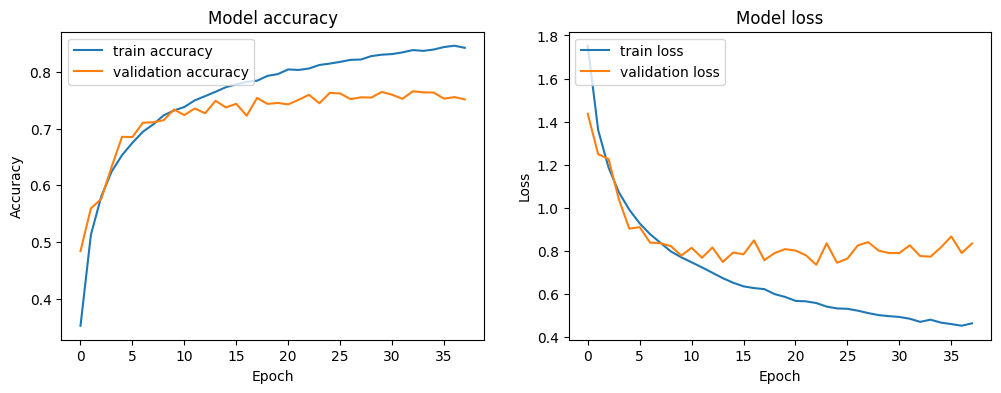

Processing confusion matrix. May take some time...


2024-06-21 10:35:59.330526: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


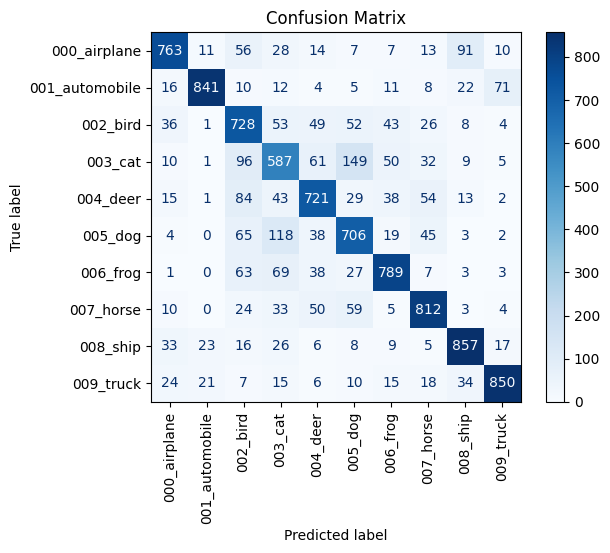

In [ ]:
# Ensaio 6.3
NUMBER_OF_EPOCHS=200
LEARNING_RATE=0.001

from tensorflow import keras
from keras import layers
from keras import regularizers

callbacks_list = [
    keras.callbacks.EarlyStopping(monitor="val_accuracy",patience=5),
    keras.callbacks.ModelCheckpoint(filepath="checkpoint_path.keras",monitor="val_loss",save_best_only=True),
]

inputs = keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
x = layers.Rescaling(1. / 255)(inputs)
x = layers.Conv2D(32, 3, activation='relu', kernel_regularizer='L1L2')(x)
x = layers.MaxPooling2D()(x)
x = layers.Conv2D(256, 3, activation='relu',kernel_regularizer='L1L2')(x)
x = layers.MaxPooling2D()(x)
x = layers.Conv2D(64, 3, activation='relu',kernel_regularizer='L1L2')(x)
x = layers.Flatten()(x)
x = layers.Dropout(0.6)(x)
x = layers.Dense(64, activation='relu',activity_regularizer='L1L2',bias_regularizer='L1L2',kernel_regularizer='L1L2')(x)
outputs = layers.Dense(10, activation='softmax')(x)


model = keras.Model(inputs, outputs)
model.summary()
model.compile(optimizer=keras.optimizers.RMSprop(learning_rate=LEARNING_RATE),loss="sparse_categorical_crossentropy",metrics=["accuracy"])
history = model.fit(train_dataset, epochs=NUMBER_OF_EPOCHS, validation_data=validation_dataset, callbacks=callbacks_list)

val_loss, val_acc = model.evaluate(test_dataset)
print('val_acc:', val_acc)
plotLossAccuracy(history)
plotConfusionMatrix(model, test_dataset)

In [ ]:
#model.save(MODELS_DIR+'/ensaio_6_3.h5')
model.save(MODELS_DIR+'/ensaio_6_3.keras')

# Interpretação de resultados: Ensaios 6.1, 6.2 e 6.3

* Infelizmente nao houve melhorias relevantes.
* O L1 simplesmente nao funcionou (foram testadas de diversas formas sempre com o mesmo resultado)
* O L2 nao melhorou o nosso modelo.
* o L1 e L2 em simultaneo conseguiu melhorar ligeiramente o nosso modelo
* Destas 3 abordagem a que ainda se revelou melhor foi o L1L2, com 76% de "accuracy" e um loss de 0.76
* A matrix de confusão mostra que mesmo assim houve alguma dificuldade em classificar "cats".


# Decisões

* Podemos voltar a colocar a questao de que nao temos um dataset suficientemente grande e assim, utilizando o L1L2 (produziu melhores resultados), mas repetir mas desta vez com data-augmentation
* No proximo ensaio vamos novamente incluir o data-augmentation, juntamente com a regularização L2




---
---

Ensaio #7

---
---

2024-06-21 10:35:59.687716: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


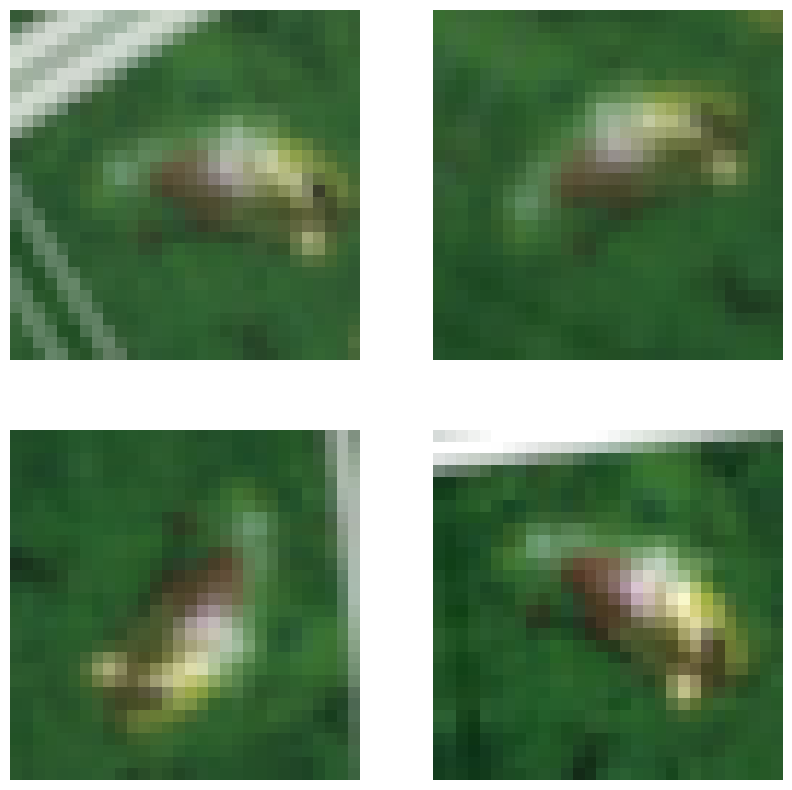

In [ ]:
data_augmentation = keras.Sequential([
layers.RandomFlip("horizontal"),
layers.RandomCrop(30,30),
layers.RandomTranslation(height_factor=0.1, width_factor=0.1),
layers.RandomContrast(0.2),
layers.RandomRotation(0.7),
])

plotDataAugmentationImagee(train_dataset, data_augmentation)

Model: "functional_37"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_23 (InputLayer)     │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_11 (Sequential)      │ (None, 30, 30, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_12 (Rescaling)        │ (None, 30, 30, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_36 (Conv2D)              │ (None, 28, 28, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_24 (MaxPooling2D) │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_37 (Conv2D)              │ (None, 12, 12, 256)    │        73,984 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_25 (MaxPooling2D) │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_38 (Conv2D)              │ (None, 4, 4, 64)       │       147,520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_12 (Flatten)            │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 64)             │        65,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 288,650 (1.10 MB)

 Trainable params: 288,650 (1.10 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/200
625/625 ━━━━━━━━━━━━━━━━━━━━ 29s 45ms/step - accuracy: 0.1971 - loss: 2.1225 - val_accuracy: 0.3026 - val_loss: 1.8873
Epoch 2/200
625/625 ━━━━━━━━━━━━━━━━━━━━ 27s 43ms/step - accuracy: 0.3049 - loss: 1.8871 - val_accuracy: 0.3438 - val_loss: 1.7661
Epoch 3/200
625/625 ━━━━━━━━━━━━━━━━━━━━ 28s 44ms/step - accuracy: 0.3402 - loss: 1.7989 - val_accuracy: 0.3729 - val_loss: 1.7198
Epoch 4/200
625/625 ━━━━━━━━━━━━━━━━━━━━ 27s 43ms/step - accuracy: 0.3746 - loss: 1.7170 - val_accuracy: 0.4011 - val_loss: 1.6539
Epoch 5/200
625/625 ━━━━━━━━━━━━━━━━━━━━ 27s 43ms/step - accuracy: 0.3927 - loss: 1.6755 - val_accuracy: 0.4076 - val_loss: 1.6179
Epoch 6/200
625/625 ━━━━━━━━━━━━━━━━━━━━ 27s 43ms/step - accuracy: 0.4125 - loss: 1.6287 - val_accuracy: 0.4523 - val_loss: 1.5291
Epoch 7/200
625/625 ━━━━━━━━━━━━━━━━━━━━ 27s 43ms/step - accuracy: 0.4310 - loss: 1.5783 - val_accuracy: 0.4421 - val_loss: 1.5461
Epoch 8/200
625/625 ━━━━━━━━━━━━━━━━━━━━ 27s 43ms/step - accuracy: 0.4432 - loss: 1

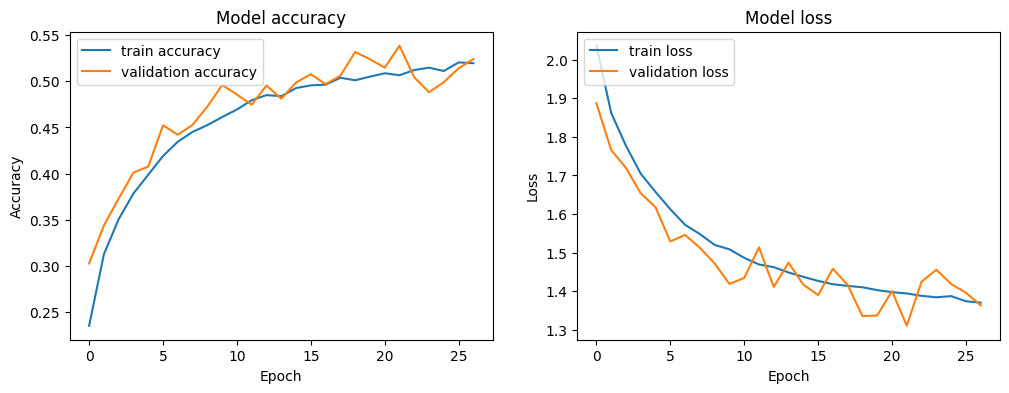

Processing confusion matrix. May take some time...


2024-06-21 10:48:34.877959: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


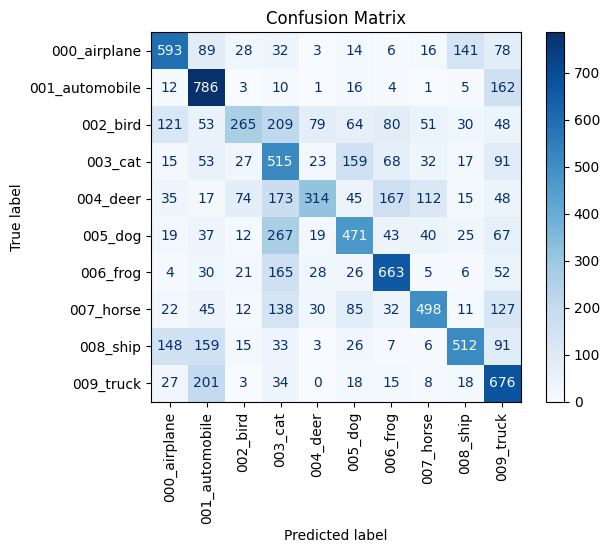

In [ ]:
# Ensaio 7
NUMBER_OF_EPOCHS=200
LEARNING_RATE=0.001

from tensorflow import keras
from keras import layers
from keras import regularizers

data_augmentation = keras.Sequential([
layers.RandomFlip("horizontal"),
layers.RandomCrop(30,30),
layers.RandomTranslation(height_factor=0.1, width_factor=0.1),
layers.RandomContrast(0.2),
layers.RandomRotation(0.7),
])


callbacks_list = [
    keras.callbacks.EarlyStopping(monitor="val_accuracy",patience=5),
    keras.callbacks.ModelCheckpoint(filepath="checkpoint_path.keras",monitor="val_loss",save_best_only=True),
]

inputs = keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
x = data_augmentation(inputs)
x = layers.Rescaling(1. / 255)(x)
x = layers.Conv2D(32, 3, activation='relu', kernel_regularizer='L1L2')(x)
x = layers.MaxPooling2D()(x)
x = layers.Conv2D(256, 3, activation='relu',kernel_regularizer='L1L2')(x)
x = layers.MaxPooling2D()(x)
x = layers.Conv2D(64, 3, activation='relu',kernel_regularizer='L1L2')(x)
x = layers.Flatten()(x)
x = layers.Dropout(0.6)(x)
x = layers.Dense(64, activation='relu',activity_regularizer='L1L2',bias_regularizer='L1L2',kernel_regularizer='L1L2')(x)
outputs = layers.Dense(10, activation='softmax')(x)

model = keras.Model(inputs, outputs)
model.summary()
model.compile(optimizer=keras.optimizers.RMSprop(learning_rate=LEARNING_RATE),loss="sparse_categorical_crossentropy",metrics=["accuracy"])
history = model.fit(train_dataset, epochs=NUMBER_OF_EPOCHS, validation_data=validation_dataset, callbacks=callbacks_list)

val_loss, val_acc = model.evaluate(test_dataset)
print('val_acc:', val_acc)
plotLossAccuracy(history)
plotConfusionMatrix(model, test_dataset)

In [ ]:
#model.save(MODELS_DIR+'/ensaio_7.h5')
model.save(MODELS_DIR+'/ensaio_7.keras')

# Interpretação de resultados: Ensaio 7

* Infelizmente nao houve melhorias relevantes, aliás ficou bastante pior e vamos descartar o data-augmentation para os próximos ensaios


# Decisões

* A partir do melhor modelo que temos neste momento, vamos utilizar um outro otimizador muito utilizado para este tipo de problemas, o "ADAM" e assim tentar perceber se conseguimos ganhar melhorias utilizadando um otimizador diferente



---
---

Ensaio #8

---
---

Model: "functional_39"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_25 (InputLayer)     │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_13 (Rescaling)        │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_39 (Conv2D)              │ (None, 30, 30, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_26 (MaxPooling2D) │ (None, 15, 15, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_40 (Conv2D)              │ (None, 13, 13, 256)    │        73,984 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_27 (MaxPooling2D) │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_41 (Conv2D)              │ (None, 4, 4, 64)       │       147,520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_13 (Flatten)            │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 64)             │        65,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 288,650 (1.10 MB)

 Trainable params: 288,650 (1.10 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/200
625/625 ━━━━━━━━━━━━━━━━━━━━ 29s 45ms/step - accuracy: 0.2571 - loss: 1.9699 - val_accuracy: 0.4645 - val_loss: 1.4766
Epoch 2/200
625/625 ━━━━━━━━━━━━━━━━━━━━ 29s 46ms/step - accuracy: 0.4636 - loss: 1.4591 - val_accuracy: 0.5383 - val_loss: 1.2802
Epoch 3/200
625/625 ━━━━━━━━━━━━━━━━━━━━ 29s 46ms/step - accuracy: 0.5269 - loss: 1.3162 - val_accuracy: 0.5810 - val_loss: 1.1664
Epoch 4/200
625/625 ━━━━━━━━━━━━━━━━━━━━ 31s 50ms/step - accuracy: 0.5645 - loss: 1.2142 - val_accuracy: 0.5971 - val_loss: 1.1074
Epoch 5/200
625/625 ━━━━━━━━━━━━━━━━━━━━ 31s 49ms/step - accuracy: 0.5975 - loss: 1.1337 - val_accuracy: 0.6151 - val_loss: 1.0753
Epoch 6/200
625/625 ━━━━━━━━━━━━━━━━━━━━ 31s 50ms/step - accuracy: 0.6168 - loss: 1.0791 - val_accuracy: 0.6225 - val_loss: 1.0314
Epoch 7/200
625/625 ━━━━━━━━━━━━━━━━━━━━ 31s 49ms/step - accuracy: 0.6337 - loss: 1.0314 - val_accuracy: 0.6689 - val_loss: 0.9344
Epoch 8/200
625/625 ━━━━━━━━━━━━━━━━━━━━ 31s 50ms/step - accuracy: 0.6540 - loss: 0

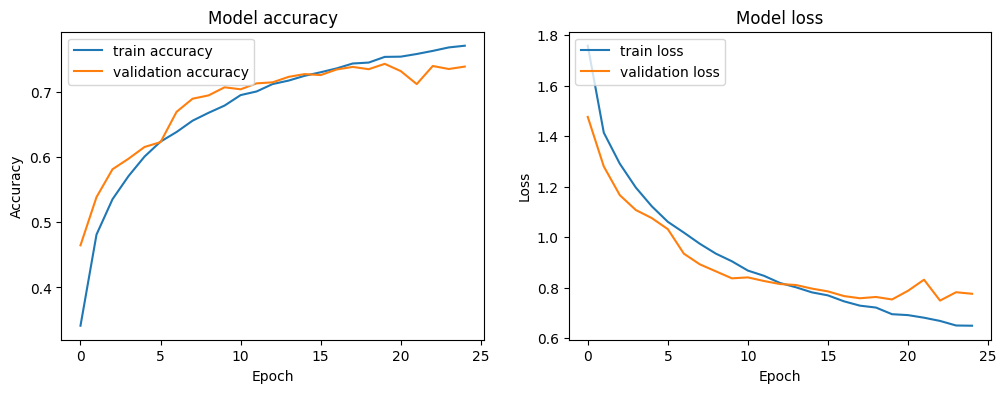

Processing confusion matrix. May take some time...


2024-06-21 11:01:25.275989: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


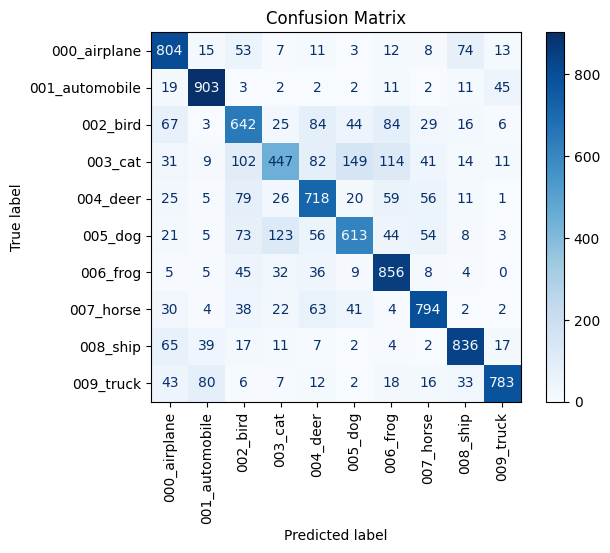

In [ ]:
# Ensaio 8
NUMBER_OF_EPOCHS=200
LEARNING_RATE=0.001

from tensorflow import keras
from keras import layers

callbacks_list = [
    keras.callbacks.EarlyStopping(monitor="val_accuracy",patience=5),
    keras.callbacks.ModelCheckpoint(filepath="checkpoint_path.keras",monitor="val_loss",save_best_only=True),
]

inputs = keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
x = layers.Rescaling(1. / 255)(inputs)
x = layers.Conv2D(32, 3, activation='relu', kernel_regularizer='L1L2')(x)
x = layers.MaxPooling2D()(x)
x = layers.Conv2D(256, 3, activation='relu',kernel_regularizer='L1L2')(x)
x = layers.MaxPooling2D()(x)
x = layers.Conv2D(64, 3, activation='relu',kernel_regularizer='L1L2')(x)
x = layers.Flatten()(x)
x = layers.Dropout(0.6)(x)
x = layers.Dense(64, activation='relu',activity_regularizer='L1L2',bias_regularizer='L1L2',kernel_regularizer='L1L2')(x)
outputs = layers.Dense(10, activation='softmax')(x)

model = keras.Model(inputs, outputs)
model.summary()
model.compile(optimizer=keras.optimizers.Adam(learning_rate=LEARNING_RATE),loss="sparse_categorical_crossentropy",metrics=["accuracy"])
history = model.fit(train_dataset, epochs=NUMBER_OF_EPOCHS, validation_data=validation_dataset, callbacks=callbacks_list)

val_loss, val_acc = model.evaluate(test_dataset)
print('val_acc:', val_acc)
plotLossAccuracy(history)
plotConfusionMatrix(model, test_dataset)

In [ ]:
#model.save(MODELS_DIR+'/ensaio_8.h5')
model.save(MODELS_DIR+'/ensaio_8.keras')

# Interpretação de resultados: Ensaios 8

* Analisando o resultado desta abordagem, não foram atingidas as metricas que temos, porém, analisando a matriz de confusao, o número de falsos positivos e falsos negativos resuziu, que torna este resultado bastante interessante


# Decisões

* Vamos incluir a funcao ReduceLROnPlateau. Esta funcionalidade permite reduzir a taxa de aprendizagem quando uma determinada métrica deixa de melhorar. Com esta abordagem podemos "forçar" a aprendizagem com outros valores de learning rate quando a aprendizagem estagna. Vamos usar a métrica "accuracy" como critério de alteração do learning rate
* Com isto vamos tentar obter mais algumas epochs de treino, com outro valor de learning rate inferior e assim tentar melhorar o modelo mais um pouco
* Vamos aplicar no treino, utilizando o otimizador RMSprop e o otimizador Adam, e assim analisar, se algum destes otimizadores tira melhor partido do ReduceLROnPlateau



---
---

Ensaio #9.1 (Usando otimizador RMSprop)

---
---

Model: "functional_41"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_26 (InputLayer)     │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_14 (Rescaling)        │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_42 (Conv2D)              │ (None, 30, 30, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_28 (MaxPooling2D) │ (None, 15, 15, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_43 (Conv2D)              │ (None, 13, 13, 256)    │        73,984 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_29 (MaxPooling2D) │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_44 (Conv2D)              │ (None, 4, 4, 64)       │       147,520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_14 (Flatten)            │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 64)             │        65,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 288,650 (1.10 MB)

 Trainable params: 288,650 (1.10 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/200
625/625 ━━━━━━━━━━━━━━━━━━━━ 35s 55ms/step - accuracy: 0.2579 - loss: 1.9983 - val_accuracy: 0.4836 - val_loss: 1.4147 - learning_rate: 0.0010
Epoch 2/200
625/625 ━━━━━━━━━━━━━━━━━━━━ 31s 49ms/step - accuracy: 0.4899 - loss: 1.4291 - val_accuracy: 0.5705 - val_loss: 1.1865 - learning_rate: 0.0010
Epoch 3/200
625/625 ━━━━━━━━━━━━━━━━━━━━ 30s 49ms/step - accuracy: 0.5664 - loss: 1.2270 - val_accuracy: 0.6244 - val_loss: 1.0541 - learning_rate: 0.0010
Epoch 4/200
625/625 ━━━━━━━━━━━━━━━━━━━━ 30s 48ms/step - accuracy: 0.6158 - loss: 1.0945 - val_accuracy: 0.6440 - val_loss: 1.0144 - learning_rate: 0.0010
Epoch 5/200
625/625 ━━━━━━━━━━━━━━━━━━━━ 30s 47ms/step - accuracy: 0.6483 - loss: 1.0106 - val_accuracy: 0.6765 - val_loss: 0.9282 - learning_rate: 0.0010
Epoch 6/200
625/625 ━━━━━━━━━━━━━━━━━━━━ 30s 48ms/step - accuracy: 0.6725 - loss: 0.9433 - val_accuracy: 0.6947 - val_loss: 0.8738 - learning_rate: 0.0010
Epoch 7/200
625/625 ━━━━━━━━━━━━━━━━━━━━ 29s 47ms/step - accuracy: 0.6

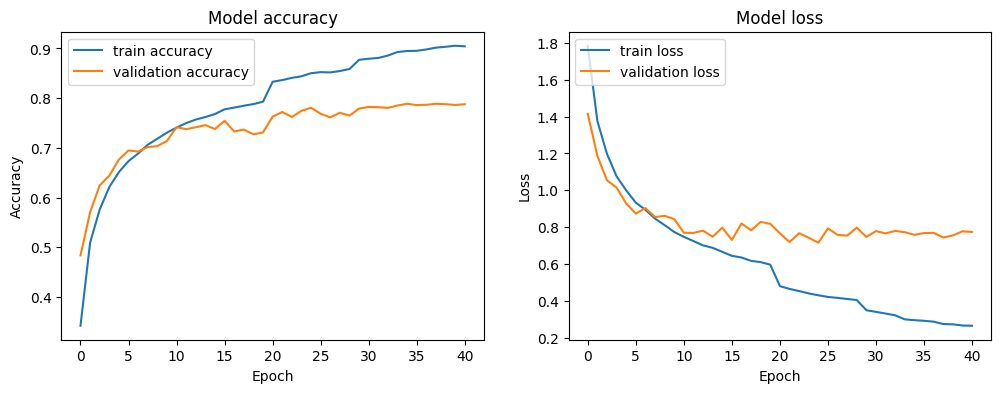

Processing confusion matrix. May take some time...


2024-06-21 11:23:49.160289: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


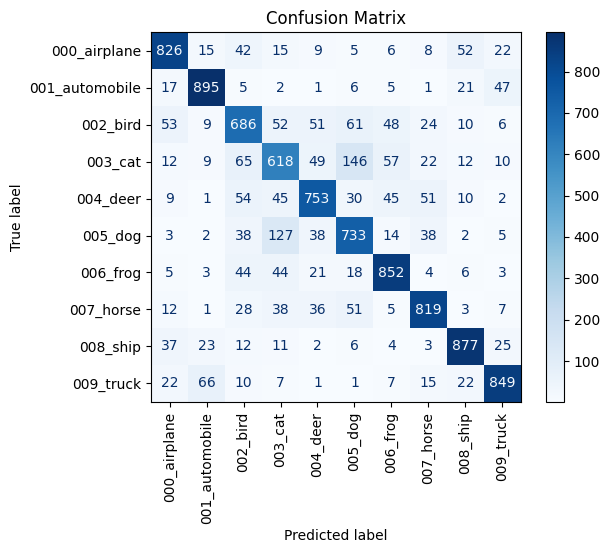

In [ ]:
# Ensaio 9.1
NUMBER_OF_EPOCHS=200
LEARNING_RATE=0.001

from tensorflow import keras
from keras import layers

callbacks_list = [
    keras.callbacks.EarlyStopping(monitor="val_accuracy",patience=6),
    keras.callbacks.ModelCheckpoint(filepath="checkpoint_path.keras",monitor="val_loss",save_best_only=True),
    keras.callbacks.ReduceLROnPlateau( monitor="val_loss", factor=0.5,patience=4, verbose=1)
]

inputs = keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
x = layers.Rescaling(1. / 255)(inputs)
x = layers.Conv2D(32, 3, activation='relu', kernel_regularizer='L1L2')(x)
x = layers.MaxPooling2D()(x)
x = layers.Conv2D(256, 3, activation='relu',kernel_regularizer='L1L2')(x)
x = layers.MaxPooling2D()(x)
x = layers.Conv2D(64, 3, activation='relu',kernel_regularizer='L1L2')(x)
x = layers.Flatten()(x)
x = layers.Dropout(0.6)(x)
x = layers.Dense(64, activation='relu',activity_regularizer='L1L2',bias_regularizer='L1L2',kernel_regularizer='L1L2')(x)
outputs = layers.Dense(10, activation='softmax')(x)


model = keras.Model(inputs, outputs)
model.summary()
model.compile(optimizer=keras.optimizers.RMSprop(learning_rate=LEARNING_RATE),loss="sparse_categorical_crossentropy",metrics=["accuracy"])
history = model.fit(train_dataset, epochs=NUMBER_OF_EPOCHS, validation_data=validation_dataset, callbacks=callbacks_list)

val_loss, val_acc = model.evaluate(test_dataset)
print('val_acc:', val_acc)
plotLossAccuracy(history)
plotConfusionMatrix(model, test_dataset)

In [ ]:
#model.save(MODELS_DIR+'/ensaio_9_1.h5')
model.save(MODELS_DIR+'/ensaio_9_1.keras')


---
---

Ensaio #9.2 (Usando otimizador Adam)

---
---

Model: "functional_51"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_32 (InputLayer)     │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_19 (Rescaling)        │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_58 (Conv2D)              │ (None, 30, 30, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_38 (MaxPooling2D) │ (None, 15, 15, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_59 (Conv2D)              │ (None, 13, 13, 256)    │        73,984 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_39 (MaxPooling2D) │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_60 (Conv2D)              │ (None, 4, 4, 64)       │       147,520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_19 (Flatten)            │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_18 (Dropout)            │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ (None, 64)             │        65,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 288,650 (1.10 MB)

 Trainable params: 288,650 (1.10 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/200
625/625 ━━━━━━━━━━━━━━━━━━━━ 26s 40ms/step - accuracy: 0.2623 - loss: 1.9632 - val_accuracy: 0.4748 - val_loss: 1.4201 - learning_rate: 0.0010
Epoch 2/200
625/625 ━━━━━━━━━━━━━━━━━━━━ 27s 43ms/step - accuracy: 0.4738 - loss: 1.4530 - val_accuracy: 0.5187 - val_loss: 1.3607 - learning_rate: 0.0010
Epoch 3/200
625/625 ━━━━━━━━━━━━━━━━━━━━ 28s 45ms/step - accuracy: 0.5269 - loss: 1.3078 - val_accuracy: 0.5786 - val_loss: 1.1610 - learning_rate: 0.0010
Epoch 4/200
625/625 ━━━━━━━━━━━━━━━━━━━━ 28s 45ms/step - accuracy: 0.5712 - loss: 1.1987 - val_accuracy: 0.6065 - val_loss: 1.0999 - learning_rate: 0.0010
Epoch 5/200
625/625 ━━━━━━━━━━━━━━━━━━━━ 28s 45ms/step - accuracy: 0.6026 - loss: 1.1191 - val_accuracy: 0.6381 - val_loss: 1.0121 - learning_rate: 0.0010
Epoch 6/200
625/625 ━━━━━━━━━━━━━━━━━━━━ 29s 46ms/step - accuracy: 0.6230 - loss: 1.0691 - val_accuracy: 0.6513 - val_loss: 0.9816 - learning_rate: 0.0010
Epoch 7/200
625/625 ━━━━━━━━━━━━━━━━━━━━ 28s 46ms/step - accuracy: 0.6

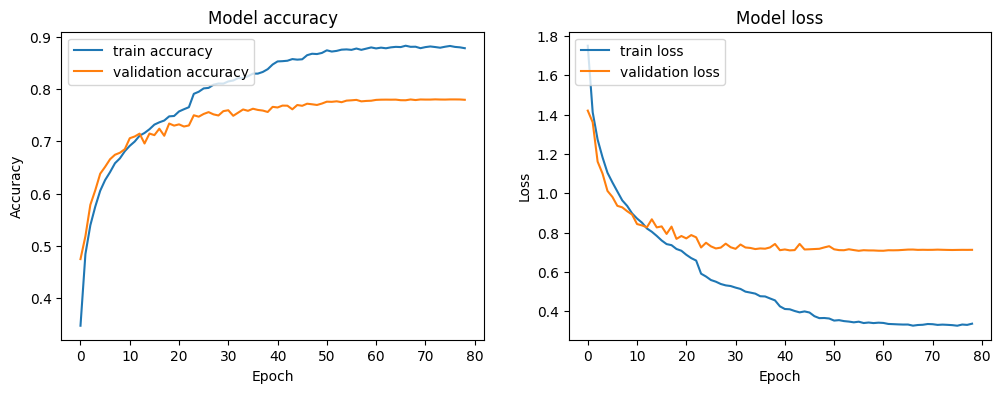

Processing confusion matrix. May take some time...


2024-06-21 12:44:55.919887: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


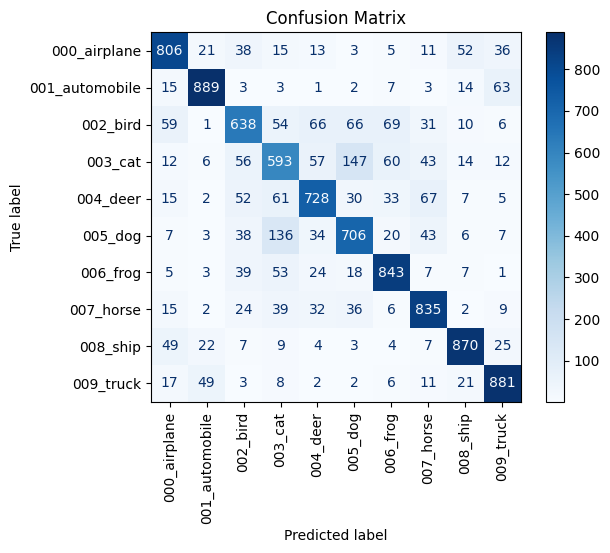

In [ ]:
# Ensaio 9.2
NUMBER_OF_EPOCHS=200
LEARNING_RATE=0.001

from tensorflow import keras
from keras import layers

callbacks_list = [
    keras.callbacks.EarlyStopping(monitor="val_accuracy",patience=6),
    keras.callbacks.ModelCheckpoint(filepath="checkpoint_path.keras",monitor="val_loss",save_best_only=True),
    keras.callbacks.ReduceLROnPlateau( monitor="val_loss", factor=0.5,patience=4, verbose=1)
]

inputs = keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
x = layers.Rescaling(1. / 255)(inputs)
x = layers.Conv2D(32, 3, activation='relu', kernel_regularizer='L1L2')(x)
x = layers.MaxPooling2D()(x)
x = layers.Conv2D(256, 3, activation='relu',kernel_regularizer='L1L2')(x)
x = layers.MaxPooling2D()(x)
x = layers.Conv2D(64, 3, activation='relu',kernel_regularizer='L1L2')(x)
x = layers.Flatten()(x)
x = layers.Dropout(0.6)(x)
x = layers.Dense(64, activation='relu',activity_regularizer='L1L2',bias_regularizer='L1L2',kernel_regularizer='L1L2')(x)
outputs = layers.Dense(10, activation='softmax')(x)


model = keras.Model(inputs, outputs)
model.summary()
model.compile(optimizer=keras.optimizers.Adam(learning_rate=LEARNING_RATE),loss="sparse_categorical_crossentropy",metrics=["accuracy"])
history = model.fit(train_dataset, epochs=NUMBER_OF_EPOCHS, validation_data=validation_dataset, callbacks=callbacks_list)

val_loss, val_acc = model.evaluate(test_dataset)
print('val_acc:', val_acc)
plotLossAccuracy(history)
plotConfusionMatrix(model, test_dataset)

In [ ]:
#model.save(MODELS_DIR+'/ensaio_9_2.h5')
model.save(MODELS_DIR+'/ensaio_9_2.keras')

# Interpretação de resultados: Ensaios 9.1, 9.2
* A utilização do ReduceLROnPlateau permitiu extender as aprendizagens até cerca das 41 "epochs" utilizando o RMSprop e 79 utilizando o Adam
* Assim os modelos foram aprendendo consequtivamente com o learning rate desde 1e-3 até 9.766e-7 (no caso do Adam) permitindo melhorar mais um pouco o modelo
* Com o ensaio 9.1 foi possível obter um modelo com "accuracy" de 79% e um loss de 0.76 utilizando o RMSprop
* Com o ensaio 9.2 foi possível obter um modelo com "accuracy" de 78% e um loss de 0.68 utilizando o Adam
* Embora a accuracy de 79% potencialmente seja melhor, do ponto de vista da generalização pretendida, um loss inferior acaba por ser mais vantajoso

# Decisões
* Vamos para os ultimos ensaios, onde vamos novamennte introduzir o BatchNormalization, que se manisfestou vantojoso já antes, com o objetivo de ficarmos com um modelo final o mais robusto possível
* Para o modelo final, que vamos treinar de seguida, dicidimos usar o otimizador Adam, que oferece melhor loss
* Mas mesmo assim ainda vamos correr o mesma arquitetura com o RMSprop só para confirmar que é o Adam é a melhor opção

Model: "functional_53"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_33 (InputLayer)     │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_20 (Rescaling)        │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_61 (Conv2D)              │ (None, 30, 30, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 30, 30, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_8 (Activation)       │ (None, 30, 30, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_40 (MaxPooling2D) │ (None, 15, 15, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_62 (Conv2D)              │ (None, 13, 13, 256)    │        73,984 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 13, 13, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_9 (Activation)       │ (None, 13, 13, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_41 (MaxPooling2D) │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_63 (Conv2D)              │ (None, 4, 4, 64)       │       147,520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 4, 4, 64)       │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_10 (Activation)      │ (None, 4, 4, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_20 (Flatten)            │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_19 (Dropout)            │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_27 (Dense)                │ (None, 64)             │        65,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_28 (Dense)                │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 290,058 (1.11 MB)

 Trainable params: 289,354 (1.10 MB)

 Non-trainable params: 704 (2.75 KB)

Epoch 1/200
625/625 ━━━━━━━━━━━━━━━━━━━━ 41s 64ms/step - accuracy: 0.3593 - loss: 1.7560 - val_accuracy: 0.4591 - val_loss: 1.4987 - learning_rate: 0.0010
Epoch 2/200
625/625 ━━━━━━━━━━━━━━━━━━━━ 42s 68ms/step - accuracy: 0.5670 - loss: 1.2042 - val_accuracy: 0.5574 - val_loss: 1.2812 - learning_rate: 0.0010
Epoch 3/200
625/625 ━━━━━━━━━━━━━━━━━━━━ 43s 68ms/step - accuracy: 0.6289 - loss: 1.0472 - val_accuracy: 0.5839 - val_loss: 1.2091 - learning_rate: 0.0010
Epoch 4/200
625/625 ━━━━━━━━━━━━━━━━━━━━ 41s 65ms/step - accuracy: 0.6596 - loss: 0.9598 - val_accuracy: 0.6011 - val_loss: 1.1564 - learning_rate: 0.0010
Epoch 5/200
625/625 ━━━━━━━━━━━━━━━━━━━━ 43s 68ms/step - accuracy: 0.6867 - loss: 0.8888 - val_accuracy: 0.6599 - val_loss: 1.0005 - learning_rate: 0.0010
Epoch 6/200
625/625 ━━━━━━━━━━━━━━━━━━━━ 41s 66ms/step - accuracy: 0.7058 - loss: 0.8291 - val_accuracy: 0.6400 - val_loss: 1.0529 - learning_rate: 0.0010
Epoch 7/200
625/625 ━━━━━━━━━━━━━━━━━━━━ 41s 65ms/step - accuracy: 0.7

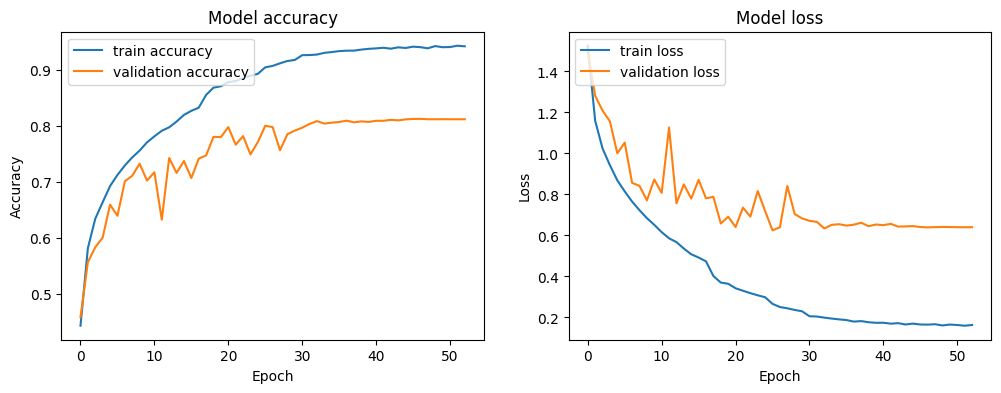

Processing confusion matrix. May take some time...


2024-06-21 13:22:52.727251: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


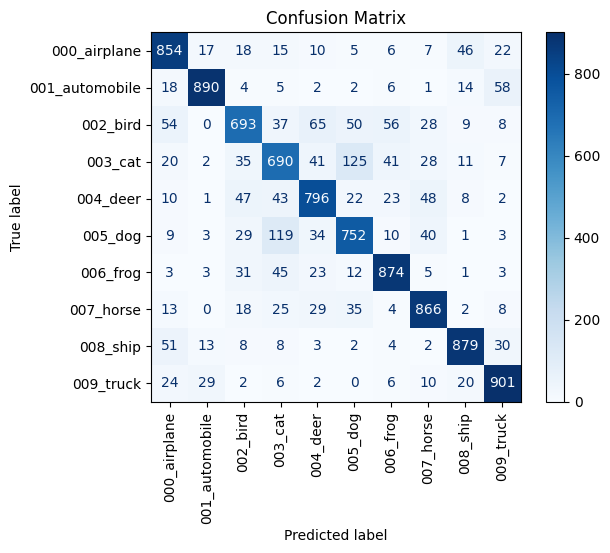

In [ ]:
# Ensaio 10.1
NUMBER_OF_EPOCHS=200
LEARNING_RATE=0.001

from tensorflow import keras
from keras import layers

callbacks_list = [
    keras.callbacks.EarlyStopping(monitor="val_accuracy",patience=6),
    keras.callbacks.ModelCheckpoint(filepath="checkpoint_path.keras",monitor="val_loss",save_best_only=True),
    keras.callbacks.ReduceLROnPlateau( monitor="val_loss", factor=0.5,patience=4, verbose=1)
]

inputs = keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
x = layers.Rescaling(1. / 255)(inputs)
x = layers.Conv2D(32, 3, kernel_regularizer='L1L2')(x)
x = layers.BatchNormalization()(x)
x = layers.Activation("relu")(x)
x = layers.MaxPooling2D()(x)
x = layers.Conv2D(256, 3, kernel_regularizer='L1L2')(x)
x = layers.BatchNormalization()(x)
x = layers.Activation("relu")(x)
x = layers.MaxPooling2D()(x)
x = layers.Conv2D(64, 3, kernel_regularizer='L1L2')(x)
x = layers.BatchNormalization()(x)
x = layers.Activation("relu")(x)
x = layers.Flatten()(x)
x = layers.Dropout(0.6)(x)
x = layers.Dense(64, activation='relu',activity_regularizer='L1L2',bias_regularizer='L1L2',kernel_regularizer='L1L2')(x)
outputs = layers.Dense(10, activation='softmax')(x)

model = keras.Model(inputs, outputs)
model.summary()
model.compile(optimizer=keras.optimizers.Adam(learning_rate=LEARNING_RATE),loss="sparse_categorical_crossentropy",metrics=["accuracy"])
history = model.fit(train_dataset, epochs=NUMBER_OF_EPOCHS, validation_data=validation_dataset, callbacks=callbacks_list)

val_loss, val_acc = model.evaluate(test_dataset)
print('val_acc:', val_acc)
plotLossAccuracy(history)
plotConfusionMatrix(model, test_dataset)

In [ ]:
#model.save(MODELS_DIR+'/ensaio_10_1.h5')
model.save(MODELS_DIR+'/ensaio_10_1.keras')

# Este é o melhor modelo, o modelo S final
model.save(MODELS_DIR+'/modelo_s.keras')
model.save(MODELS_DIR+'/modelo_s.h5')

# conversão para tensorflowjs
import tensorflowjs as tfjs
tfjs.converters.save_keras_model(model, 'py8_js_model')

failed to lookup keras version from the file,
    this is likely a weight only file


Model: "functional_55"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_34 (InputLayer)     │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_21 (Rescaling)        │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_64 (Conv2D)              │ (None, 30, 30, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 30, 30, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_11 (Activation)      │ (None, 30, 30, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_42 (MaxPooling2D) │ (None, 15, 15, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_65 (Conv2D)              │ (None, 13, 13, 256)    │        73,984 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 13, 13, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_12 (Activation)      │ (None, 13, 13, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_43 (MaxPooling2D) │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_66 (Conv2D)              │ (None, 4, 4, 64)       │       147,520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ (None, 4, 4, 64)       │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_13 (Activation)      │ (None, 4, 4, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_21 (Flatten)            │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_20 (Dropout)            │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_29 (Dense)                │ (None, 64)             │        65,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_30 (Dense)                │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 290,058 (1.11 MB)

 Trainable params: 289,354 (1.10 MB)

 Non-trainable params: 704 (2.75 KB)

Epoch 1/200
625/625 ━━━━━━━━━━━━━━━━━━━━ 41s 65ms/step - accuracy: 0.3873 - loss: 1.7211 - val_accuracy: 0.4570 - val_loss: 1.5186 - learning_rate: 0.0010
Epoch 2/200
625/625 ━━━━━━━━━━━━━━━━━━━━ 40s 65ms/step - accuracy: 0.5746 - loss: 1.1953 - val_accuracy: 0.5695 - val_loss: 1.2042 - learning_rate: 0.0010
Epoch 3/200
625/625 ━━━━━━━━━━━━━━━━━━━━ 41s 65ms/step - accuracy: 0.6318 - loss: 1.0404 - val_accuracy: 0.5446 - val_loss: 1.3297 - learning_rate: 0.0010
Epoch 4/200
625/625 ━━━━━━━━━━━━━━━━━━━━ 52s 84ms/step - accuracy: 0.6741 - loss: 0.9403 - val_accuracy: 0.6358 - val_loss: 1.0804 - learning_rate: 0.0010
Epoch 5/200
625/625 ━━━━━━━━━━━━━━━━━━━━ 39s 63ms/step - accuracy: 0.6972 - loss: 0.8613 - val_accuracy: 0.6553 - val_loss: 0.9997 - learning_rate: 0.0010
Epoch 6/200
625/625 ━━━━━━━━━━━━━━━━━━━━ 43s 68ms/step - accuracy: 0.7133 - loss: 0.8191 - val_accuracy: 0.6558 - val_loss: 0.9680 - learning_rate: 0.0010
Epoch 7/200
625/625 ━━━━━━━━━━━━━━━━━━━━ 43s 69ms/step - accuracy: 0.7

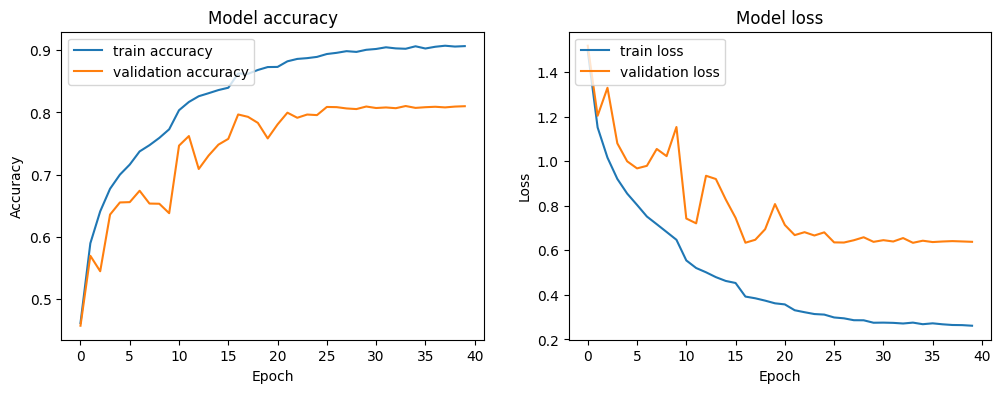

Processing confusion matrix. May take some time...


2024-06-21 13:50:47.242975: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


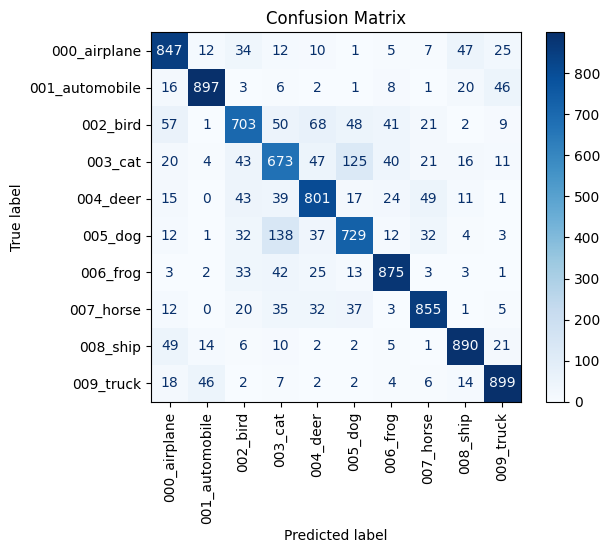

In [ ]:
# Ensaio 10.2
NUMBER_OF_EPOCHS=200
LEARNING_RATE=0.001

from tensorflow import keras
from keras import layers

callbacks_list = [
    keras.callbacks.EarlyStopping(monitor="val_accuracy",patience=6),
    keras.callbacks.ModelCheckpoint(filepath="checkpoint_path.keras",monitor="val_loss",save_best_only=True),
    keras.callbacks.ReduceLROnPlateau( monitor="val_loss", factor=0.5,patience=4, verbose=1)
]

inputs = keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
x = layers.Rescaling(1. / 255)(inputs)
x = layers.Conv2D(32, 3, kernel_regularizer='L1L2')(x)
x = layers.BatchNormalization()(x)
x = layers.Activation("relu")(x)
x = layers.MaxPooling2D()(x)
x = layers.Conv2D(256, 3, kernel_regularizer='L1L2')(x)
x = layers.BatchNormalization()(x)
x = layers.Activation("relu")(x)
x = layers.MaxPooling2D()(x)
x = layers.Conv2D(64, 3, kernel_regularizer='L1L2')(x)
x = layers.BatchNormalization()(x)
x = layers.Activation("relu")(x)
x = layers.Flatten()(x)
x = layers.Dropout(0.6)(x)
x = layers.Dense(64, activation='relu',activity_regularizer='L1L2',bias_regularizer='L1L2',kernel_regularizer='L1L2')(x)
outputs = layers.Dense(10, activation='softmax')(x)


model = keras.Model(inputs, outputs)
model.summary()
model.compile(optimizer=keras.optimizers.RMSprop(learning_rate=LEARNING_RATE),loss="sparse_categorical_crossentropy",metrics=["accuracy"])
history = model.fit(train_dataset, epochs=NUMBER_OF_EPOCHS, validation_data=validation_dataset, callbacks=callbacks_list)

val_loss, val_acc = model.evaluate(test_dataset)
print('val_acc:', val_acc)
plotLossAccuracy(history)
plotConfusionMatrix(model, test_dataset)

In [ ]:
#model.save(MODELS_DIR+'/ensaio_9_4.h5')
model.save(MODELS_DIR+'/ensaio_9_4.keras')

# Interpretação de resultados: Ensaios 10.1 e 10.2
* Neste momento temos um modelo final onde foram aplicadas as tecnicas de otimização do modelo com melhores resultados, obtendo assim um modelo de "accuracy" de cerca de 82% e uma loss de cerca de 0.6297
* Mesmo assim o ensaio 10.2 (RMSprop) permitiu obter um modelo com "accuracy" de 81% e um loss de 0.6345, que também é um resultado satisfatório
* A matriz de confusão mostra que temos de facto modelos equilibrados, mas que se nota uma pequena fragiliadade na deteção de "cats" e "dogs"


# Conclusão

* A criação deste projeto modelo S, envolveu uma sequencia de passos e de abordagens, que foram utilizadas durante todo o processo, e que gradualmente foram introduzidos e aplicados acções de modo a tirar o máximo partido do sistema com as condições existentes, neste caso o dataset fornecido.
* Utilizando muitas tecnicas e excluindos outras que não funcionaram como se esperaria chegou-se a um modelo final que apresenta métricas que nós consideramos satisfatórias, sabendo a evolução desde o ponto de partida, isto é, chegámos a um ponto que já não dá para melhorar muito mais, dado o dataset disponível.
* A utilização do otimizador Adam, do BatchNormalization, do ReduceLROnPlateau, do Regularizer L1L2 (Regularizer l1 em conjunto com o Regularizer l2), o dropout, revelaram-se uteis e foram utilizados no treino do modelo final


# Arquitetura final
```
inputs = keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
x = layers.Rescaling(1. / 255)(inputs)
x = layers.Conv2D(32, 3, kernel_regularizer='L1L2')(x)
x = layers.BatchNormalization()(x)
x = layers.Activation("relu")(x)
x = layers.MaxPooling2D()(x)
x = layers.Conv2D(256, 3, kernel_regularizer='L1L2')(x)
x = layers.BatchNormalization()(x)
x = layers.Activation("relu")(x)
x = layers.MaxPooling2D()(x)
x = layers.Conv2D(64, 3, kernel_regularizer='L1L2')(x)
x = layers.BatchNormalization()(x)
x = layers.Activation("relu")(x)
x = layers.Flatten()(x)
x = layers.Dropout(0.6)(x)
x = layers.Dense(64, activation='relu',activity_regularizer='L1L2',bias_regularizer='L1L2',kernel_regularizer='L1L2')(x)
outputs = layers.Dense(10, activation='softmax')(x)
```
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
| Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_33 (InputLayer)     │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_20 (Rescaling)        │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_61 (Conv2D)              │ (None, 30, 30, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 30, 30, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_8 (Activation)       │ (None, 30, 30, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_40 (MaxPooling2D) │ (None, 15, 15, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_62 (Conv2D)              │ (None, 13, 13, 256)    │        73,984 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 13, 13, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_9 (Activation)       │ (None, 13, 13, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_41 (MaxPooling2D) │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_63 (Conv2D)              │ (None, 4, 4, 64)       │       147,520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 4, 4, 64)       │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_10 (Activation)      │ (None, 4, 4, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_20 (Flatten)            │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_19 (Dropout)            │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_27 (Dense)                │ (None, 64)             │        65,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_28 (Dense)                │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

# Notas

* Todos os modelos criados, foram gravados na pasta models
* O Modelo S final escolhido por nós irás ser gravado com o nome modelo_s.keras

* Para a nossa aplicação web, vamos utilizar o tensorflowjs para importar e correr o modelo_s, e para isso utilizámos a função uma função própria do tensorflowjs para exportar/converter esse modelo
```
import tensorflowjs as tfjs
tfjs.converters.save_keras_model(model, 'py8_js_model')
```
* Uma nota: o tensorflowjs é incompativel com o python3.11, versão utilizada por nós neste projeto. Para exportar o modelo tensorflowjs, tivemos, de uma forma temporária, correr a função "tfjs.converters.save_keras_model" com o ambiente com python 3.8


## Funcionalidade utilizadas durante este trabalho pratico
  * Early stopping
  * BatchNormalization
  * Data augmentation
  * Dropout
  * Regularizer L1, L2 e L1L2
  * optimizers.Adam
  * ReduceLROnPlateau